# Data Mining Lab 2
#### Team 2:  Patricia Goresen, Jeffrey Lancon, Brychan Manry, George Sturrock

## Introduction
The source of baseball data for this lab is the Sean Lahman Baseball Database [ http://www.seanlahman.com/baseball-archive/statistics/]. Often cited as the most complete baseball database, the data set includes twenty-seven data tables and millions of records covering most non-proprietary baseball data pertaining to offense, fielding, pitching, payroll, player demographics, team statistics, manager data and much more.  

In previous assignments, the team has focused on MLB team level data.  For this Lab, we will focus on player level data.  The focus will be on position players.  Pitchers will not be viewed in this study, due to the uniqueness of their position.  This will allow for more exploration of baseball data and provide a broader variety of regression and classification scenarios.  

This lab will focus on the analysis of four specific tables containing player level details in the Lahman Baseball Database:  Batting, Fielding, Salaries, and People.  The names of the different tables accurately describe the contents.  For example, the Batting table contains offensive statics per year for each player.  The tables are at different grains.  The ultimate intention is to have a single dataframe accurately combining all relevant features of the four tables.  The methods used to achieve this goal will be presented below.  

In addition to the Lahman’s data sets, two additional dataset will be merged into the final dataset, MinSalary.csv and Inflation.csv.  The MinSalary.csv is a listing of minimum salaries for MLB players by year.  The Inflation.csv is a salary inflation index from 1985 to 2017 that was created using CPI data courtesy of Minneapolis Federal Reserve.

In this Lab, the team will focus on two predictive tasks.  First, models will be trained to predict the salary of a player.  Second, a classification models will be created to attempt to categorize players by position using attributes other than position.  Three different models will be created for each predictive task.

Many new player-level variables will be explored.  A full list of variables and their meanings are provided in *Data Preparation - Part 2* section of this notebook.

## Data Preparation - Part 1
### Import Data

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns

batting = pd.read_csv('./data/Batting.csv')
fielding = pd.read_csv('./data/Fielding.csv')
salaries = pd.read_csv('./data/Salaries.csv')
inflation = pd.read_csv('./data/Inflation.csv')
minSalary = pd.read_csv('./data/MinimumSalaries.csv')

#Rename Column Names to standardize with Lahman database columns and remove spaces
inflation = inflation.rename(index=str, columns={'Year': 'yearID'})
minSalary = minSalary.rename(index=str, columns={'Year': 'yearID', 'MinSalaries ': 'MinSalaries'})

print('Batting', batting.info())
print('Fielding', fielding.info())
print('Salaries', salaries.info())
print('Inflation', inflation.info())
print('Minimum Salary', minSalary.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104324 entries, 0 to 104323
Data columns (total 24 columns):
playerID     104324 non-null object
yearID       104324 non-null int64
stint        104324 non-null int64
teamID       104324 non-null object
lgID         103586 non-null object
G            104324 non-null int64
G_batting    0 non-null float64
AB           104324 non-null int64
R            104324 non-null int64
H            104324 non-null int64
2B           104324 non-null int64
3B           104324 non-null int64
HR           104324 non-null int64
RBI          103568 non-null float64
SB           101956 non-null float64
CS           80832 non-null float64
BB           104324 non-null int64
SO           97974 non-null float64
IBB          67722 non-null float64
HBP          101507 non-null float64
SH           98255 non-null float64
SF           68259 non-null float64
GIDP         78921 non-null float64
G_old        0 non-null float64
dtypes: float64(11), int64(10), object(3

In [21]:
print("Shape of DataFrames:", "Batting:", batting.shape, "Fielding:", fielding.shape, "Salaries:", salaries.shape, "Inflation:", inflation.shape, "Minimum Salary:", minSalary.shape)

Shape of DataFrames: Batting: (104324, 24) Fielding: (138838, 18) Salaries: (26428, 5) Inflation: (33, 4) Minimum Salary: (51, 2)


### Subsetting by Year

As can be seen above, a one to one match does not exist between the four source tables. The process of creating dataframes which can be merged into a single dataframe will begin with row level filtering. Only records from the 1985 season and greater will be used for analysis in this assignment. 1985 was chosen for two reasons.  First, salary data only goes back to 1985.  Second, the evolution of the game and its players have changed quite a bit since beginning of the professional game of baseball. Selecting only records from the 1985 season and forward provides a 32-year data set while eliminating data that would likely lead to erroneous results.  

In [22]:
batting = batting[batting.yearID > 1984]
fielding = fielding[fielding.yearID > 1984]
salaries = salaries[salaries.yearID > 1984]
minSalary = minSalary[minSalary.yearID > 1984]

print("Shape of DataFrames:", "Batting:", batting.shape, "Fielding:", fielding.shape, "Salaries:", salaries.shape, "Inflation:", inflation.shape, "Minimum Salary:", minSalary.shape)

Shape of DataFrames: Batting: (42071, 24) Fielding: (54560, 18) Salaries: (26428, 5) Inflation: (33, 4) Minimum Salary: (33, 2)


### Batting

The Batting table will be the driver for the overall consolidated data frame.  In other words, fielding, salaries and awards will be merged into the Batting data frame.  First, categorical variables such as Team and League ID which offer limited predictive or structural value will be dropped from the data frame.  The G_old column is missing values in every row and will be dropped as well.

In [23]:
batting = batting.drop(['teamID', 'lgID', 'G_old', 'G_batting', 'stint'], axis=1)
#Drop rows with no basic statistics are recorded in a year
#batting = batting[(batting[['AB', 'BB']] != 0).all(axis=1)]
batting = batting[(batting[['AB']] != 0).all(axis=1)]

There are approximately 1300 instances remaining where a player has more than one record per year in the batting data frame.  This is to be expected as player trades and multiple stints in the major league do occur in a single season.  These instances will be consolidated into a single row.

In [24]:
#Identify Instances where a player has more than one batting record per year.
df = batting.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.G > 1]
print(df)

#Consolidate and Aggreagate
print(batting.groupby(['yearID', 'playerID']).sum().reset_index())
battingFinal = batting.groupby(['yearID', 'playerID']).sum().reset_index()

print(battingFinal.info())
print(battingFinal.describe())

        playerID  yearID  G  AB  R  H  2B  3B  HR  RBI  SB  CS  BB  SO  IBB  \
21     abbotku01    1998  2   2  2  2   2   2   2    2   2   2   2   2    2   
35     abernbr01    2003  2   2  2  2   2   2   2    2   2   2   2   2    2   
41     abnersh01    1991  2   2  2  2   2   2   2    2   2   2   2   2    2   
54     abreubo01    2006  2   2  2  2   2   2   2    2   2   2   2   2    2   
60     abreubo01    2012  2   2  2  2   2   2   2    2   2   2   2   2    2   
95     ackledu01    2015  2   2  2  2   2   2   2    2   2   2   2   2    2   
114    adamsma01    2017  2   2  2  2   2   2   2    2   2   2   2   2    2   
151    affelje01    2006  2   2  2  2   2   2   2    2   2   2   2   2    2   
162    agbaybe01    2002  2   2  2  2   2   2   2    2   2   2   2   2    2   
172    aguaylu01    1988  2   2  2  2   2   2   2    2   2   2   2   2    2   
217    aldremi01    1991  2   2  2  2   2   2   2    2   2   2   2   2    2   
220    aldremi01    1995  2   2  2  2   2   2   2   

             yearID             G            AB             R             H  \
count  28904.000000  28904.000000  28904.000000  28904.000000  28904.000000   
mean    2001.899668     64.405999    179.436998     23.963465     46.882923   
std        9.296812     49.930809    199.226342     30.293061     56.408233   
min     1985.000000      1.000000      1.000000      0.000000      0.000000   
25%     1994.000000     22.000000     11.000000      1.000000      2.000000   
50%     2002.000000     48.000000     77.000000      8.000000     17.000000   
75%     2010.000000    108.000000    328.000000     41.000000     84.000000   
max     2017.000000    163.000000    716.000000    152.000000    262.000000   

                 2B            3B            HR           RBI            SB  \
count  28904.000000  28904.000000  28904.000000  28904.000000  28904.000000   
mean       9.033836      1.011175      5.231214     22.714226      3.398630   
std       11.475622      1.887903      8.563477    

In [25]:
print("Index:", battingFinal.index)
print("Columns:", battingFinal.columns)

Index: RangeIndex(start=0, stop=28904, step=1)
Columns: Index(['yearID', 'playerID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP'],
      dtype='object')


### Fielding
The Fielding table contains most of the common defensive statistics in baseball.  The grain of this table is by player, year, stint and position.  It is common for players to play more than one position over the course of a season (year).  However, most players have a primary position.  There is also the concept of a utility player.  This a player who has no primary position and plays a significant number of games in many positions.  The end objective is to produce a final fielding file with data summarized at the player and year grain.  As this lab is focused on everyday position players, pitchers will be dropped from the fielding data frame.  

In [26]:
#fielding = fielding[fielding.POS != 'P']
print(fielding.describe())

             yearID         stint             G            GS       InnOuts  \
count  54560.000000  54560.000000  54560.000000  54545.000000  54545.000000   
mean    2002.048259      1.080334     35.466697     25.017087    670.333633   
std        9.417926      0.285750     40.092292     39.596628   1035.107817   
min     1985.000000      1.000000      1.000000      0.000000      0.000000   
25%     1994.000000      1.000000      6.000000      0.000000     55.000000   
50%     2002.000000      1.000000     20.000000      6.000000    202.000000   
75%     2010.000000      1.000000     50.000000     31.000000    667.000000   
max     2017.000000      4.000000    163.000000    162.000000   4388.000000   

                 PO             A             E            DP           PB  \
count  54560.000000  54560.000000  54560.000000  54560.000000  3651.000000   
mean      74.490836     28.644446      1.887353      6.913783     3.074226   
std      175.176243     71.381596      3.563496     19

From the above describe statement, it's easy to see WP (wild pitch) and ZR (zone rating) are missing values in the entire column.  The two columns will be dropped from the fielding data frame.  To maintain consistency with the batting data frame, team and league will be dropped as well.  

In [27]:
fielding = fielding.drop(['teamID', 'lgID', 'WP', 'ZR'], axis=1)

There is high rate of missing values in the "PB", "SB" and "CS" columns.  This does make sense as these are statistics specific to catchers. Example: 'CS' - times player caught opponent stealing.  

The data was spot checked to verify these are accurate missing values.  These missing values will be replaced with zeroes.

In [28]:
fielding.fillna(value={'PB': 0, 'SB': 0, 'ZR': 0, 'CS': 0}, inplace = True)
print(fielding.info())
print(fielding.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54560 entries, 0 to 138837
Data columns (total 14 columns):
playerID    54560 non-null object
yearID      54560 non-null int64
stint       54560 non-null int64
POS         54560 non-null object
G           54560 non-null int64
GS          54545 non-null float64
InnOuts     54545 non-null float64
PO          54560 non-null int64
A           54560 non-null int64
E           54560 non-null float64
DP          54560 non-null int64
PB          54560 non-null float64
SB          54560 non-null float64
CS          54560 non-null float64
dtypes: float64(6), int64(6), object(2)
memory usage: 6.2+ MB
None
             yearID         stint             G            GS       InnOuts  \
count  54560.000000  54560.000000  54560.000000  54545.000000  54545.000000   
mean    2002.048259      1.080334     35.466697     25.017087    670.333633   
std        9.417926      0.285750     40.092292     39.596628   1035.107817   
min     1985.000000      1.0000

In [29]:
#Identify Players who played multiple positions per year.
df = fielding.groupby(['playerID', 'yearID']).count().reset_index()
df = df[df.stint > 1]

In [30]:
#Identify Primary Postion per Player per Year Based on Max Games at a position.
df = fielding.groupby(['playerID', 'yearID', 'POS']).sum().reset_index()
df = df.groupby(['playerID', 'yearID', 'POS'])['G'].max().reset_index()
#df = df.groupby(['playerID', 'yearID', 'POS']).max()['G']
df = df.sort_values(by=['playerID', 'yearID', 'G'], ascending=[True, True, False])
print(df.describe())

primePOS = pd.DataFrame()
svPlayerID = ''
svYearID = 0

for index, row in df.iterrows():
    #print (row["playerID"], row["yearID"], row['POS'], row['G'])
    if (svPlayerID != row['playerID'] or svYearID != row['yearID']):
        primePOS = primePOS.append({'playerID': row['playerID'], 'yearID': row['yearID'], 'Primary': row['POS']}, ignore_index=True)
        #print(svPlayerID, row["playerID"], svYearID, row["yearID"], row['POS'], row['G'])
        svPlayerID = row['playerID']
        svYearID = row['yearID']
    else:
        continue
  

             yearID             G
count  50860.000000  50860.000000
mean    2001.978687     38.046854
std        9.438938     41.475898
min     1985.000000      1.000000
25%     1994.000000      6.000000
50%     2002.000000     23.000000
75%     2010.000000     55.000000
max     2017.000000    163.000000


In [31]:
#Condense Fielding Dataframe into one row per player per year.
fielding = fielding.groupby(['playerID', 'yearID']).sum().reset_index()

#Merge Primary Position into condensed Fielding data frame
fieldingFinal = pd.merge(fielding, primePOS, on=['playerID', 'yearID'], how='left')

print(fieldingFinal.describe())

            yearID         stint             G            GS       InnOuts  \
count  38453.00000  38453.000000  38453.000000  38453.000000  38453.000000   
mean    2002.02923      1.532858     50.322810     35.486360    950.858139   
std        9.39001      1.209722     45.210944     46.258138   1210.394556   
min     1985.00000      1.000000      1.000000      0.000000      0.000000   
25%     1994.00000      1.000000     14.000000      0.000000    114.000000   
50%     2002.00000      1.000000     34.000000     14.000000    337.000000   
75%     2010.00000      2.000000     73.000000     52.000000   1407.000000   
max     2017.00000     23.000000    195.000000    163.000000   4388.000000   

                 PO             A             E            DP            PB  \
count  38453.000000  38453.000000  38453.000000  38453.000000  38453.000000   
mean     105.693184     40.642889      2.677918      9.809794      0.291889   
std      207.296502     87.089853      4.322111     23.57125

### Salaries

The Salaries table contains yearly salary figures for players beginning in 1985.  This data will be condensed into one row per player per year similar to the fielding and batting tables.  League and Team will be dropped from this data frame as well.

In [32]:
#Drop League and Team
salaries = salaries.drop(['teamID', 'lgID'], axis=1)

#Summarize salaries at the year and player level
salariesFinal = salaries.groupby(['playerID', 'yearID']).sum().reset_index()

print(salariesFinal.describe())

             yearID        salary
count  26323.000000  2.632300e+04
mean    2000.901797  2.093953e+06
std        8.913938  3.460182e+06
min     1985.000000  0.000000e+00
25%     1994.000000  3.000000e+05
50%     2001.000000  5.543910e+05
75%     2009.000000  2.362500e+06
max     2016.000000  3.300000e+07


### Merge Batting, Fielding and Salaries  

The Batting, Fielding, and Salaries dataset will be merged using playerID and yearID as indexes.

In [33]:
#Merge Batting and Fielding
#Uncomment below if player dataframe needs to be deleted prior to rerunning a merge
#del player

player = pd.merge(battingFinal, fieldingFinal, on=['playerID', 'yearID'], how='left')

#Drop Pitchers from merged dataframe
player = player[player.Primary != 'P']

#Merge Salaries
player = pd.merge(player, salariesFinal, on=['playerID', 'yearID'], how='left')

print(player.info())
print(player.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 32 columns):
yearID      19820 non-null int64
playerID    19820 non-null object
G_x         19820 non-null int64
AB          19820 non-null int64
R           19820 non-null int64
H           19820 non-null int64
2B          19820 non-null int64
3B          19820 non-null int64
HR          19820 non-null int64
RBI         19820 non-null float64
SB_x        19820 non-null float64
CS_x        19820 non-null float64
BB          19820 non-null int64
SO          19820 non-null float64
IBB         19820 non-null float64
HBP         19820 non-null float64
SH          19820 non-null float64
SF          19820 non-null float64
GIDP        19820 non-null float64
stint       19536 non-null float64
G_y         19536 non-null float64
GS          19536 non-null float64
InnOuts     19536 non-null float64
PO          19536 non-null float64
A           19536 non-null float64
E           19536 non-null float64


### Merge Inflation and Minimum Salary Data with Player DataFrame

In [34]:
player = pd.merge(player, inflation, on=['yearID'], how='left')
player = pd.merge(player, minSalary, on=['yearID'], how='left')

print(player.info())
print(player.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 36 columns):
yearID                 19820 non-null int64
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19536 non-nul

### Uniqueness
A review of the number of unique values per column shown below show little evidence there are issues with low or near zero variance.  Attributes with relatively low uniqueness counts such as triple (3B), stint and minimum salary per year for MLB players (MinSalaries) are to be expected.  

In [35]:
df = player.nunique(dropna = False)
print(df)

yearID                   33
playerID               3497
G_x                     163
AB                      694
R                       146
H                       231
2B                       59
3B                       23
HR                       65
RBI                     157
SB_x                     81
CS_x                     29
BB                      148
SO                      206
IBB                      43
HBP                      33
SH                       29
SF                       18
GIDP                     34
stint                    22
G_y                     189
GS                      165
InnOuts                4198
PO                     1270
A                       525
E                        40
DP                      160
PB                       28
SB_y                    130
CS_y                     65
Primary                   7
salary                 2359
Annual Average           33
AnnualPercentChange      23
Mult2017                 33
MinSalaries         

### Missing Values
Missing values per columns are summarized in the table shown below.  Many of these attributes result from merging the batting data frame with the fielding data frame.  These missing values have been spot checked at appear to be valid.  It is common to have a player not record any fielding statistics during a season.  
For example, every game played in an American League stadium will have two designated hitters in the starting lineup.  These players typically hit for their team's pitcher and do not have to play in the field.  Additionally, the National League employs the double switch as a strategy.  This can also lead to players hitting without fielding.  There are a variety of additional scenarios which could lead to this as well.  The missing values for each column will be evaluated and handled individually.
 

In [36]:
df = player.isnull().sum()
df = df[df > 0]
df = pd.DataFrame({
    'n Missing' : df,
    '% Missing' : ((df / player.shape[0])*100).round(2)})

cm = sns.light_palette("red", as_cmap=True)
df.style.background_gradient(cmap=cm)

,n Missing,% Missing
stint,284,1.43
G_y,284,1.43
GS,284,1.43
InnOuts,284,1.43
PO,284,1.43
A,284,1.43
E,284,1.43
DP,284,1.43
PB,284,1.43
SB_y,284,1.43


#### Fill Missing Values
Stint will be filled with 1 when missing.  The remaining columns with high rates of missing values will be filled with zeroes as these are instances where the player did not field a position.  Salary will be filled with zeros in this step, but will receive additional treatment below.

In [37]:
colls = []
colls = ['G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'SB_y', 'CS_y', 'salary']


for c in colls:
    player[c].fillna(0, inplace=True)
    
#Fill missing stint with 1
player['stint'].fillna(1, inplace = True)
    
#Fill missing Primary Position with "DH"
player['Primary'].fillna('DH', inplace = True)

##### Missing Salary 
In the Lahman Baseball Database, players who do not start the year on an MLB roster do not have salaries listed in the table.  The league minimum salary will be used for these instances.  Looking up individual contracts details for each player with a missing salary would be counterproductive.  These instances were filled with zero in the step above.  

A second salary column named "adjSalary2" will be created to fill the zeros with the league minimum salary for that year with inflation adjusted values.  

In [38]:
#Inflation Adjusted Salary
player['adjSalary'] = (player.salary * player.Mult2017)
player['adjMinSalaries'] = (player.MinSalaries * player.Mult2017)

player['adjSalary2'] = np.where(player['adjSalary'] == 0, player['adjMinSalaries'], player['adjSalary'])

print(player.info())
print(player.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 39 columns):
yearID                 19820 non-null int64
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19820 non-nul

#### Final Check for Missing Values

In [39]:
print(player.isnull().sum())

yearID                 0
playerID               0
G_x                    0
AB                     0
R                      0
H                      0
2B                     0
3B                     0
HR                     0
RBI                    0
SB_x                   0
CS_x                   0
BB                     0
SO                     0
IBB                    0
HBP                    0
SH                     0
SF                     0
GIDP                   0
stint                  0
G_y                    0
GS                     0
InnOuts                0
PO                     0
A                      0
E                      0
DP                     0
PB                     0
SB_y                   0
CS_y                   0
Primary                0
salary                 0
Annual Average         0
AnnualPercentChange    0
Mult2017               0
MinSalaries            0
adjSalary              0
adjMinSalaries         0
adjSalary2             0
dtype: int64


#### Subset by Number of Games to Reduce Outliers
As shown in the boxplot below, the interquartile bottom limit for games played from the batting data is 30.  This value will be used to subset the data and reduce noise in the data set.  It is common for players are called up from the minor leagues and/or optioned down to the minor leagues during the year.  These players, with very short stints, often play multiple positions or no position and their yearly statistics are not representative of a full-time player.  MLB player's union has a minimum of 43 games-played for a player to qualify for the union pension plan, so 30 was deemed to be an appropriate minimum number of games.

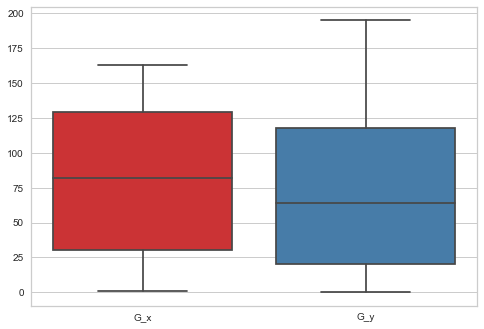

In [40]:
sns.boxplot(data=player[['G_x', 'G_y']], palette="Set1")

### New Features

In [41]:
#Batting Average
player['Bavg'] = (player.H / player.AB)

#Slugging
player['Slug'] = ((player.H - player['2B'] - player['3B'] - player.HR) + (player['2B']*2) + (player['3B']*3) + player.HR*4) / player.AB

#OBP
player['OBP'] = (player.H + player.BB + player.HBP) / (player.AB + player.BB + player.HBP + player.SF)

#Fielding Percentage - the sum of putouts and assists divided by the number of total chances (putouts + assists + errors)
player['FPct'] = (player.PO + player.A) / (player.PO + player.A + player.E)
player['FPct'].fillna(0, inplace = True)

print(player.info())
print(player.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19820 entries, 0 to 19819
Data columns (total 43 columns):
yearID                 19820 non-null int64
playerID               19820 non-null object
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19820 non-nul

#### MLB Players - Number of Years in League

The amount of time a player has been in the league can play an important role in a player’s salary. Rookie contracts are non-negotiable for the first few years (e.g., close to the league minimum), and then arbitrated after that until the player makes it to free agency (usually ~5 years). Once in free agency a player can go to the highest bidding team and salaries can increase significantly.  

To account for artificial limits early on and any potential relationship with free-agency contracts later in careers we calculated the season number ("seasonNum") variable by taking the difference between the current season year and a player's MLB debut year. This is a good proxy for time in the league for players. Even if a player is bumped back and forth between the minors and majors, once they get their MLB debut the clock starts ticking on their rookie contract and time to free agency.


In [42]:
# Load Career Dates from 'People' File
careerDates = pd.read_csv('./data/People.csv')[['playerID', 'debut']]
careerDates['debut'] = pd.to_datetime(careerDates['debut'], errors='coerce')
careerDates = careerDates.dropna() # some very old players have different date formats
careerDates['debutYear'] = careerDates['debut'].dt.year.astype(int)

# Join debutYear to player DF
player = player.set_index('playerID').join(careerDates[['playerID', 'debutYear']].set_index('playerID'))
player.reset_index(level=0, inplace=True)
player['seasonNum'] = (player['yearID'] - player['debutYear']) + 1

#### Write UnScaled Data to CSV
To give model developers flexibility to analyze and experiement with scaled and unscaled data, Unscaled CSV files will be created.

In [43]:
player.to_csv('./data/player.csv', sep=',', encoding='utf-8')

#Players with no Salary
playerNoSalary = player[player.salary > 0]
playerNoSalary.to_csv('./data/playerNoSal.csv', sep=',', encoding='utf-8')

### Scaling
As determined in prior assignments, the baseball data must be scaled.  Some attributes are ratios while others are cummulative integers.  

In [44]:
#Baseball Data must be scaled due to the combination of percentages and cummulative statistics.  
from sklearn.preprocessing import StandardScaler
#Save key attributes which cannot be scaled prior to scaling
df = player[['yearID', 'playerID', 'Primary']]

#Drop Attributes which are not needed, can't be scaled or shouldn't be scaled
player = player.drop(['AnnualPercentChange', 'Mult2017', "Annual Average", 'yearID', 'playerID', 'Primary'], axis=1)

colNames = player.columns

#Scale data
scaler = StandardScaler()
playerScaled = scaler.fit_transform(player)
playerScaled = pd.DataFrame(playerScaled, columns=colNames)

#Merge Primary Position back into the dataframe
#player = pd.concat([df, player], axis=1, ignore_index=True)
playerScaled['yearID'] = df['yearID']
playerScaled['playerID'] = df['playerID']
playerScaled['Primary'] = df['Primary']

player['yearID'] = df['yearID']
player['playerID'] = df['playerID']
player['Primary'] = df['Primary']

print(player.info())
print(player.describe())
print(playerScaled.info())
print(playerScaled.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19820 entries, 0 to 19819
Data columns (total 42 columns):
G_x               19820 non-null int64
AB                19820 non-null int64
R                 19820 non-null int64
H                 19820 non-null int64
2B                19820 non-null int64
3B                19820 non-null int64
HR                19820 non-null int64
RBI               19820 non-null float64
SB_x              19820 non-null float64
CS_x              19820 non-null float64
BB                19820 non-null int64
SO                19820 non-null float64
IBB               19820 non-null float64
HBP               19820 non-null float64
SH                19820 non-null float64
SF                19820 non-null float64
GIDP              19820 non-null float64
stint             19820 non-null float64
G_y               19820 non-null float64
GS                19820 non-null float64
InnOuts           19820 non-null float64
PO                19820 non-null float64
A    

#### Write Scaled Data to CSV file

In [45]:
playerScaled.to_csv('./data/playerscale.csv', sep=',', encoding='utf-8')

#Players with no Salary
playerNoSalaryScale = player[playerScaled.salary > 0]
playerNoSalaryScale.to_csv('./data/playerNoSalscale.csv', sep=',', encoding='utf-8')

In [46]:
# Save pandas data frames as pickles
player.to_pickle("./analysisdata/player.pkl")
playerNoSalary.to_pickle("./analysisdata/playerNoSal.pkl")
playerScaled.to_pickle("./analysisdata/playerScaled.pkl")
playerNoSalaryScale.to_pickle("./analysisdata/playerNoSalScale.pkl")

------
## Data Preparation 2
The overall strategy for the data preparation is to provide data files to the model developers which offer ultimate flexibility and do not restrict or discard data unless necessary.  There are two final data sets.

The first is the player data set.  It is the combination of batting, fielding, salary and inflation data per player per year.  Much effort was spent assuring only one summarized record per player per year exists in this file.  

The second is a subset of the player file for players with a salary.  As this is expected to be utilized to for the salary prediction task.  Both versions have also been scaled and saved as new data files if the model developers choose to use scaled versions of the data.  

Finally, all files are available to the modelers as CSV, pickle or in memory as pandas data frames if the modeler chooses to build from this notebook.  
The table below is a full description of the final file.


**Data Description (Including New Features)**

| Attribute      | Category      | Type     | DF_Type | Description                                                                           |
|----------------|---------------|----------|---------|---------------------------------------------------------------------------------------|
| yearID         | Informational | Interval | int64   | The professional baseball season.                                                     |
| playerID       | Informational | nominal  | object  | Unique identifier for the player.                                                     |
| Primary        | Informational | nominal  | object  | The player's primary position during the year.                                        |
| G_x            | Informational | Interval | int64   | The number of games where the player batted during the specified year.                |
| R              | Batting       | Interval | int64   | Total runs scored by the player during the year.                                      |
| AB             | Batting       | Interval | int64   | Total at bats by the player during the year.                                          |
| H              | Batting       | Interval | int64   | Total hist by the player during the year.                                             |
| 2B             | Batting       | Interval | int64   | Total doubles by the player during the year.                                          |
| 3B             | Batting       | Interval | int64   | Total triples by the player during the year.                                          |
| HR             | Batting       | Interval | int64   | Total home runs for the player during the year.                                       |
| RBI            | Batting       | Interval | int64   | Total Runs Batted In by the player during the year.                                   |
| BB             | Batting       | Interval | float64 | Total bases on balls or walks by the player during the year.                          |
| SO             | Batting       | Interval | float64 | Total strikeouts by the player during the year.                                       |
| SB_x           | Batting       | Interval | float64 | Total stolen bases by the player during the year.                                     |
| CS_x           | Batting       | Interval | float64 | Total time the player was caught stealing during the year.                            |
| HBP            | Batting       | Interval | float64 | Total number of times the player was hit by a pitch during the year.                  |
| SF             | Batting       | Interval | float64 | Total number of sacrifice flies by the player during the year.                        |
| GIDP           | Batting       | Interval | float64 | The number of times the player grounded into a double play during the year.           |
| stint          | Fielding      | Interval | float64 | The number of stints the player had during the year.                                  |
| G_y            | Fielding      | Interval | float64 | The number of games the player played in the field.                                   |
| GS             | Fielding      | Interval | float64 | The number of games started in the field by the player.                               |
| InnOuts        | Fielding      | Interval | float64 | The number of outs the player played during the year.                                 |
| PO             | Fielding      | Interval | float64 | The number of put outs by the player during the year.                                 |
| A              | Fielding      | Interval | float64 | The number of assists by the player during the year.                                  |
| E              | Fielding      | Interval | float64 | Total errors by the player during the year.                                           |
| DP             | Fielding      | Interval | float64 | Total double plays by the player during the year.                                     |
| PB             | Fielding      | Interval | float64 | The number of passed balls by the player during the year.                             |
| SB_y           | Fielding      | Interval | float64 | The number of opponent stolen bases allowed by the player during the year.            |
| CS_y           | Fielding      | Interval | float64 | The number of time the player caught an opponent stealing during the year.            |
| salary         | Salary        | Interval | float64 | The total salary for the player per season.                                           |
| MinSalaries    | Salary        | Interval | float64 | The league minimum salary for the season.                                             |
| adjSalary      | Salary        | Interval | float64 | The player's salary adjusted for inflation in 2017 dollars.                           |
| adjMinSalaries | Salary        | Interval | float64 | The yearly league minimum salary adjusted for inflation in 2017 dollars.              |
| adjSalary2     | Salary        | Interval | float64 | The same as adjSalary except players without a salary listed will use adjMinSalaries. |
| Bavg           | New Feature   | Ratio    | float64 | The player's batting average.                                                         |
| Slug           | New Feature   | Ratio    | float64 | The player's slugging percentage.                                                     |
| OBP            | New Feature   | Ratio    | float64 | The player's on base percentage.                                                      |
| FPct           | New Feature   | Ratio    | float64 | Aggregate fielding percentage by the player.                                          |
| debutYear      | New Feature   | Interval | int32   | The player's first year in the major leagues.                                         |
| seasonNum      | New Feature   | Interval | int64   | The number of seasons the player accumulated up to that point in time.                |


------
## Modeling and Evaluation 1
Numerous evaluation metrics exists for different analysis types (i.e. precision, recall, F-measure, accuracy, R2, MSE,…).  Which one you chose depends on the dataset, type of analysis being conducted, and what information you are trying to extract from the analysis.

**Categorical Analysis – Position Prediction**

Classification metrics tend to be geared more towards binary outcomes (Y/N, 1/0) and must be adapted to work with multiclass classification scenarios.  The multiclass classification evaluation metrics that is most appropriate for this dataset and our goal of predicting player’s position is Accuracy.  Accuracy determines the overall % correct classifications predicted by the model.

**Regression Analysis – Salary Prediction**

Regression model evaluation metrics quantify the difference between the predicted values and the actual values (MSE, R2, adjR2,…). Coefficient of determination (R2), will be used as our evaluation metric.  R2 measures the proportion of the variance of the response variable (Salary) that is predicted by the algorithm. 


------
## Modeling and Evaluation 2
To prevent overfitting, improve generalization outside the given dataset, and evaluate the effectiveness of the predictive model, a 10-fold cross validation system with a random 80:20 (training/test) split on the dataset will be employed.  Analysis results may require modification of these parameters, but all data will employ a K-fold cross validation system.  

**Categorical Analysis - Testing/Training Data**

The categorical analysis being performed is attempting to classify the MLB player’s primary position on team’s roster.  Looking back at the dataset, you can easily determine that the number of players classified as a position are unevenly distributed, producing a class-imbalance.  The number of outfielders (OF) is 7408 while the number of designated-hitters (DH) is 284, a 26X difference.  Stratified sampling will be employed, to ensure that an adequate number of instances of each position appear in the training datasets. If regular random sampling was performed, it’s conceivable that a training dataset may not contain an adequate proportion of DH instances to properly classify the class.   

**Regression Analysis - Testing/Training Data**

The regression analysis being performed is attempting to determine the MLB player’s salaries, given the fielding/batting statistics present in the dataset.  Simple random sampling with 10-fold cross validation will be employed on the dataset for regression analysis models.


------
## Modeling and Evaluation 3
This section will build the models used to solve the tasks of position and salary prediction.  Three models per task with be presented for evaluation.  These are two predictive tasks spanning two different modes of machine learning.  The Position prediction is a classification task.  Given the available features the models will attempt to determine which position each players's primary position.  Salary predcition is a regression task where each player's salary, a continuous variable, will be predicted.  As previsously stated, these approaches will utilize different cross validation approaches and measurements to produce the optimal model.   

#### Data Exploration
Task 1 data exploration will pickup where the data preparation section stopped.  The player data is reset and read into this section.  It is checked for missing values and uniqueness.  The number of players per position is also presented as this presents a key input into the position classification task.

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv("./data/player.csv")
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19820 entries, 0 to 19819
Data columns (total 46 columns):
Unnamed: 0             19820 non-null int64
playerID               19820 non-null object
yearID                 19820 non-null int64
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null 

(19820, 46)

There are no missing values.

In [2]:
df.isnull().values.ravel().sum()

0

There are no uniqueness concerns.

In [3]:
# Determine the number of unique 'classes' of each variable
print ('Size of the dataset:', df.shape)
print ('Number of unique classes:\n', df.nunique())

Size of the dataset: (19820, 46)
Number of unique classes:
 Unnamed: 0             19820
playerID                3497
yearID                    33
G_x                      163
AB                       694
R                        146
H                        231
2B                        59
3B                        23
HR                        65
RBI                      157
SB_x                      81
CS_x                      29
BB                       148
SO                       206
IBB                       43
HBP                       33
SH                        29
SF                        18
GIDP                      34
stint                     21
G_y                      189
GS                       164
InnOuts                 4197
PO                      1269
A                        524
E                         39
DP                       159
PB                        27
SB_y                     129
CS_y                      64
Primary                    7
salary      

In [4]:
print ('Number of unique classes:', df['Primary'].nunique())

Number of unique classes: 7


In [5]:
df['Primary'].unique()

array(['1B', 'DH', 'OF', 'SS', '2B', '3B', 'C'], dtype=object)

The following graph showns a total breakdown of players by position.  The imbalance between players per position is a key point for the position classification task.  A stratified cross validation method is favored for classification tasks to assist with accounting for the imbalance.  

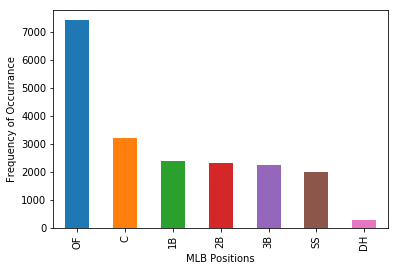

OF    7408
C     3208
1B    2389
2B    2304
3B    2230
SS    1997
DH     284
Name: Primary, dtype: int64

In [6]:
# Examine 'Position' variable in dataset
# Plot frequency of Positions 'classes'
%matplotlib inline
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
df['Primary'].value_counts().plot(ax=ax, kind='bar')
plt.xlabel('MLB Positions')
plt.ylabel('Frequency of Occurrance')
plt.show()
df['Primary'].value_counts()

In [7]:
# Printing Head and Tail of Dataset
df.iloc[np.r_[0:6, -6:0]]

,Unnamed: 0,playerID,yearID,G_x,AB,R,H,2B,3B,HR,...,MinSalaries,adjSalary,adjMinSalaries,adjSalary2,Bavg,Slug,OBP,FPct,debutYear,seasonNum
0,0,abadan01,2001,1,1,0,0,0,0,0,...,200000.0,0.0,276800.0,276800.0,0.000000,0.000000,0.000000,1.000000,2001,1
1,1,abadan01,2003,9,17,1,2,0,0,0,...,300000.0,0.0,399600.0,399600.0,0.117647,0.117647,0.210526,0.972973,2001,3
2,2,abadan01,2006,5,3,0,0,0,0,0,...,327000.0,397632.0,397632.0,397632.0,0.000000,0.000000,0.400000,0.000000,2001,6
3,3,abbotje01,1997,19,38,8,10,1,0,1,...,150000.0,0.0,229050.0,229050.0,0.263158,0.368421,0.263158,1.000000,1997,1
4,4,abbotje01,1998,89,244,33,68,14,1,12,...,170000.0,263200.0,255680.0,263200.0,0.278689,0.491803,0.298450,0.970588,1997,2
5,5,abbotje01,1999,17,57,5,9,0,0,2,...,200000.0,375105.0,294200.0,375105.0,0.157895,0.263158,0.222222,0.961538,1997,3
19814,19814,zupcibo01,1994,36,92,10,18,4,1,1,...,109000.0,0.0,180286.0,180286.0,0.195652,0.293478,0.226804,1.000000,1991,4
19815,19815,zuvelpa01,1985,81,190,16,48,8,1,0,...,60000.0,0.0,136740.0,136740.0,0.252632,0.305263,0.310680,0.972696,1982,4
19816,19816,zuvelpa01,1986,21,48,2,4,1,0,0,...,60000.0,0.0,134160.0,134160.0,0.083333,0.104167,0.169811,0.965517,1982,5
19817,19817,zuvelpa01,1987,14,34,2,6,0,0,0,...,62500.0,0.0,134875.0,134875.0,0.176471,0.176471,0.176471,1.000000,1982,6


### Task 1:  Position Classification
Typically every player on a MLB roster has a primary position.  Players at these positions can have different characteristics which make them well suited for their job.  However, there are real life occurences which complicate assigning a position to each player.  Players commonly play different positions through the year.  This can be due to injuries, days off, in-game adjustments and more. The following models will attempt to wade through these instances to classify each player by position utilizing available data.  

#### Task 1.1 - K-Nearest Neighbors (KNN)

In [8]:
#Drop Categorial Columns with no predictive ability
df.drop(['Annual Average', 'AnnualPercentChange', 'Mult2017', 'MinSalaries', 'salary', 'adjSalary', 'adjMinSalaries','playerID','Unnamed: 0','yearID'], inplace=True, axis=1)

In [9]:
# Printing Head and Tail of Dataset
df.iloc[np.r_[0:6, -6:0]]

,G_x,AB,R,H,2B,3B,HR,RBI,SB_x,CS_x,...,SB_y,CS_y,Primary,adjSalary2,Bavg,Slug,OBP,FPct,debutYear,seasonNum
0,1,1,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,1B,276800.0,0.000000,0.000000,0.000000,1.000000,2001,1
1,9,17,1,2,0,0,0,0.0,0.0,1.0,...,0.0,0.0,1B,399600.0,0.117647,0.117647,0.210526,0.972973,2001,3
2,5,3,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,DH,397632.0,0.000000,0.000000,0.400000,0.000000,2001,6
3,19,38,8,10,1,0,1,2.0,0.0,0.0,...,0.0,0.0,OF,229050.0,0.263158,0.368421,0.263158,1.000000,1997,1
4,89,244,33,68,14,1,12,41.0,3.0,3.0,...,0.0,0.0,OF,263200.0,0.278689,0.491803,0.298450,0.970588,1997,2
5,17,57,5,9,0,0,2,6.0,1.0,1.0,...,0.0,0.0,OF,375105.0,0.157895,0.263158,0.222222,0.961538,1997,3
19814,36,92,10,18,4,1,1,8.0,0.0,1.0,...,0.0,0.0,OF,180286.0,0.195652,0.293478,0.226804,1.000000,1991,4
19815,81,190,16,48,8,1,0,4.0,2.0,0.0,...,0.0,0.0,2B,136740.0,0.252632,0.305263,0.310680,0.972696,1982,4
19816,21,48,2,4,1,0,0,2.0,0.0,0.0,...,0.0,0.0,SS,134160.0,0.083333,0.104167,0.169811,0.965517,1982,5
19817,14,34,2,6,0,0,0,0.0,0.0,0.0,...,0.0,0.0,2B,134875.0,0.176471,0.176471,0.176471,1.000000,1982,6


##### Converting Player Positions to numeric values

For KNN Analysis, we will be converting the 'Primary' position variable to a numeric value.  The numeric values chosen are the typical position indicators used by MLB teams:  
Catcher(C):  2  
1st Base(1B):  3  
2nd Base(2B):  4  
Short Stop(SS): 6  
OutFielder(OF): 7  
DesignatedHitters(DH): 10

In [10]:
#Convert Player positions to numeric indicators
df['Primary'] = df['Primary'].map({'1B':3, '2B':4, '3B':5, 'C':2, 'SS':6, 'OF':7, 'DH':10})

In [11]:
#Set minimum games at 30
df = df[df['G_x'] > 30]
df = df.reset_index(drop=True)
df['Primary'].value_counts()

7     5682
2     2128
3     1832
5     1742
4     1735
6     1572
10      79
Name: Primary, dtype: int64

#### KNN Classification Parameter Optimization with GridSearch

K-Nearest Neighbor (KNN) classification is valid option for this dataset since the dataset has been preprocessed and it has no missing values.  Parameter selections are critical to the performance of KNN classifiers; therefore, substantial time and effort was put forth to fully investigate the optimal parameters. 

##### Parameter Analysis:

*Algorithms:*  Algorithm used to compute the nearest neighbors can be ‘auto’matically determine the most appropriate algorithm to use for the given dataset/parameters, so it was left as default in our GridSearch

##### GridSearch Parameters:

*n_neighbors:* 	Number of neighbors to use in the analysis.  Preliminary analyses were conducted to find a desired range of for number of neighbors.  From these analyses, it was determined that the optimal number of neighbors is below 15.  Above 15, the accuracy plateaus and start to decrease.

*Leaf_size:*  	The leaf size was adjusted, using: 10, 30, and 100 as the parameters.  While there is an over-head penalty with using smaller leaves, accuracy may increase, so we will use it in our Grid Search.

*Metric:*		How distance is measure between datapoints can be adjusted.  The 2 options chosen were ‘minkowski’ and ‘euclidean’.

*Weights:* 	Both uniform and distance were looked at.  ‘Uniform’ weight-all neighboring points get equal weight.  ‘Distance’ weights points by the inverse of their distance.


*Predictor Variables:*  
Many of the predictor variable have different scaling, so to ensure all variables were treated equally in the analysis, all predictor variables are scaled to have a mean of 0 and Standard deviation of 1.

In [12]:
#KNN Classification 10-fold cross-validation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
import warnings
warnings.filterwarnings('ignore')

#Xtemp = df.drop(['Primary'], axis=1)
# create variables we are more familiar with
y = df.Primary
X = df.drop(['Primary'], axis=1)

#yhat = np.zeros(y.shape) # we will fill this with predictions

# Scaling training variables
scl = StandardScaler()
X = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

ClsEstimator = KNeighborsClassifier(n_jobs = -1)

parameters = { 'n_neighbors':[3,5,13]
              ,'weights': ['uniform','distance']
              ,'leaf_size': [10,30]
              ,'metric': ['minkowski','euclidean']
             }
#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
ClsGridSearch = GridSearchCV(estimator=ClsEstimator
                   #, n_jobs=10 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
ClsGridSearch.fit(X, y)


The GridSearch algorithm determined the following optimal paramters for K-Neighbors Algorithn.

*Leaf-Size:* 10  
*Number of Neighbors:* 13  
*Distance Matric:* Minkowski  
*Weights:* Uniform

In [13]:
#Use the best parameters for our KNN classifier
ClsGridSearchEst = ClsGridSearch.best_estimator_
print(ClsGridSearchEst)

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')


Re-ran the KNN classification analysis with the optimal algorithm parameters that were determined by the parameter GridSearch.  

*KNN Classifier accuracy* with optimal Parameters is *80.8%*

In [14]:
yhat = np.zeros(y.shape) # initializing variable

for train, test in cv.split(X,y):
    # Use Results parameters from GridSearch to run KNN Classifier model
    clf_knn = KNeighborsClassifier(n_neighbors=13, weights='uniform',metric='minkowski', algorithm='auto',p=2,leaf_size=10)
    clf_knn.fit(X[train],y[train])
    yhat[test] = clf_knn.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
#print KNN accuracy with corresponding parameter settings
print('KNN classifier accuracy with optimal parameters is: %.3f'%(total_accuracy))

KNN classifier accuracy with optimal parameters is: 0.787


##### Confusion Matrix:
Below is the confusion matrix for the KNN position classification analysis. The matrix was normalized to show percentage of classifications in lieu of actual number of predictions, so that it can easily be interpreted. 

Excellent Predictability:
Positions; 1st Base(3) 96%, ShortStop(6) 97%, and Designated Hitter(10) 100% 
Moderate Predictability:
Position; 3rd Base(5) 74%, had moderate predictability. When misclassified, 3rd base was most often mistaken for 1st Base (3).
Average Predictability:
Positions; Catcher(2) 66%, 2nd Base(4) 51%, and Outfield(7) 60% were often misclassified as one another.  The classification of these 3 positions is sub optimal.


Normalized confusion matrix


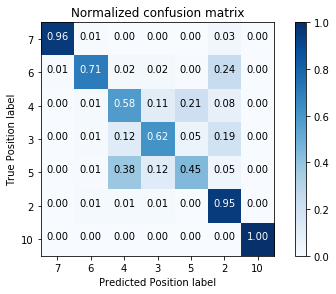

In [15]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = df['Primary'].unique()

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Position label')
    plt.xlabel('Predicted Position label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Task 1.2 - Linear Discriminant Analysis (LDA)
Linear Discriminant Analysis offers both a method for classification and feature reduction to components which make it a useful model for this data set.

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import yellowbrick as yb
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

player = pd.read_csv('./data/player.csv')
playerNoSal = pd.read_csv('./data/playerNoSal.csv')
playerScale = pd.read_csv('./data/playerscale.csv')
playerNoSalScale = pd.read_csv('./data/playerNoSalscale.csv')

In [14]:
player = player.drop(['Unnamed: 0'], axis=1)
playerNoSal = playerNoSal.drop(['Unnamed: 0'], axis=1)
playerScale = playerScale.drop(['Unnamed: 0'], axis=1)
playerNoSalScale = playerNoSalScale.drop(['Unnamed: 0'], axis=1)

print(player.info())
print(playerNoSal.info())
print(playerScale.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19820 entries, 0 to 19819
Data columns (total 45 columns):
playerID               19820 non-null object
yearID                 19820 non-null int64
G_x                    19820 non-null int64
AB                     19820 non-null int64
R                      19820 non-null int64
H                      19820 non-null int64
2B                     19820 non-null int64
3B                     19820 non-null int64
HR                     19820 non-null int64
RBI                    19820 non-null float64
SB_x                   19820 non-null float64
CS_x                   19820 non-null float64
BB                     19820 non-null int64
SO                     19820 non-null float64
IBB                    19820 non-null float64
HBP                    19820 non-null float64
SH                     19820 non-null float64
SF                     19820 non-null float64
GIDP                   19820 non-null float64
stint                  19820 non-nul

#### LDA Priors
The Lahman Database does not distinguish between outfielders by position (left field, center field, right field).  All outfielders are categorized as "OF".  This does make sense as outfielders often play multiple outfield positions depending upon the baseball stadium, pitcher and game situation.  However, this poses a challenge for classification as 37% of the population by position is outfielders whereas the other positions are roughly 11% of the populations.  LDA allows us to specify prior population percentages to assist with classification.  The priors are shown below.

In [15]:
df = player[['yearID', 'playerID', 'Primary']]
df = df.groupby(['Primary']).count().reset_index()
df['Pct'] = round((df.playerID / len(player)), 4)
df = df.drop(['yearID', 'playerID'], axis=1)
print(df)

myPriors = np.array(df.Pct)
print(myPriors)

  Primary     Pct
0      1B  0.1205
1      2B  0.1162
2      3B  0.1125
3       C  0.1619
4      DH  0.0143
5      OF  0.3738
6      SS  0.1008
[0.1205 0.1162 0.1125 0.1619 0.0143 0.3738 0.1008]


#### LDA Parameter Selection
GridSearchCV will be utilized to assist with parameter selection for LDA.  StratifedShuffleSplit will be the cross validation method passed to GridSearchCV.  

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, GridSearchCV, ParameterGrid
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import metrics as mt

#Create Lists to Automate LDA Model Search
#mySolv = ['lsqr', 'eigen', 'svd']
mySolv = ['lsqr', 'svd']
myNComponents = list(range(2,20,2))
myShrink = [None, 'auto']
#parms = {'n_components': [myNComponents], 'shrinkage': [myShrink], 'solver': [mySolv]}
parms = {'n_components': [myNComponents], 'solver': [mySolv]}
parmGrid = (list(ParameterGrid(parms)))
print(parmGrid)

#Create Target and Data sets
X = playerScale.drop(['Primary', 'playerID', 'yearID'], axis=1)
y = playerScale['Primary']

#Save for M&E 4
XT1 = X
yT1 = y

#yhat = np.zeros(y.shape)
yhat = np.empty(y.shape,dtype=str)
yhat2 = np.empty(y.shape,dtype=str)

#Create cross validation interator
cv = StratifiedKFold(n_splits=10)
cv2 = StratifiedShuffleSplit(y, n_iter = 10, test_size = 0.2, train_size=0.8)

#Create arrays from data frame columns as input into dataframe iterators
X = X.values
y = y.values

### Parameter Grid Search for LDA and Stratified Shuffle Split
gscv = GridSearchCV(estimator=LinearDiscriminantAnalysis(priors=myPriors), 
                   n_jobs=10, 
                   verbose=1, 
                   param_grid = parmGrid, 
                   scoring='accuracy')

for trainidx, testidx in cv2:
    X_train = X[trainidx] 
    X_test = X[testidx] 
    y_train = y[trainidx]
    y_test = y[testidx]    
    gscv.fit(X_train, y_train)
    print("GSCV CV2 LDA Accuracy:", gscv.score(X_test, y_test))


[{'n_components': [2, 4, 6, 8, 10, 12, 14, 16, 18], 'solver': ['lsqr', 'svd']}]


As shown below, the optimal LDA model identified by GridSearchCV is two components with least squares regression.  

In [22]:
print("Best Estimator:", gscv.best_estimator_)
print("Best Parameters:", gscv.best_params_)
print("Best Score:", gscv.best_score_)

Best Estimator: LinearDiscriminantAnalysis(n_components=2,
              priors=array([0.1205, 0.1162, 0.1125, 0.1619, 0.0143, 0.3738, 0.1008]),
              shrinkage=None, solver='lsqr', store_covariance=False,
              tol=0.0001)
Best Parameters: {'solver': 'lsqr', 'n_components': 2}
Best Score: 0.7288092835519677


#### LDA:  Fit and Predict Using Best Estimators
With minimal training, the LDA model produces good results.  As expected,  second basemen and short stops are difficult to classify.  While not necessarily interchangeable, players at these two positions do have similar traits.  Traditionally, players at this position are prized for their defensive abilities and are allowed to be below average hitters as teams like to be sound defensively "up the middle" of the field.  The Confusion Matrix heatmap offers a visual view showing how players were classified compared the their actual positions.  

             precision    recall  f1-score   support

         1B       0.95      0.59      0.73       478
         2B       0.61      0.49      0.54       461
         3B       0.71      0.57      0.63       446
          C       1.00      0.73      0.84       641
         DH       0.61      1.00      0.75        57
         OF       0.67      0.97      0.79      1482
         SS       0.70      0.43      0.53       399

avg / total       0.76      0.73      0.72      3964



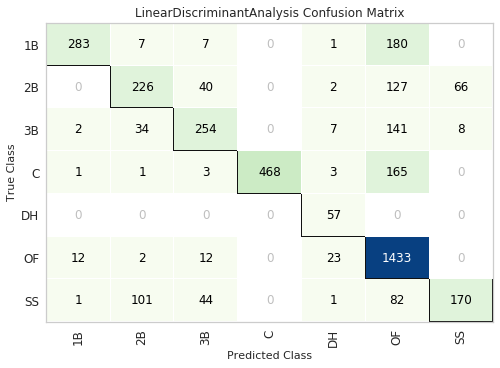

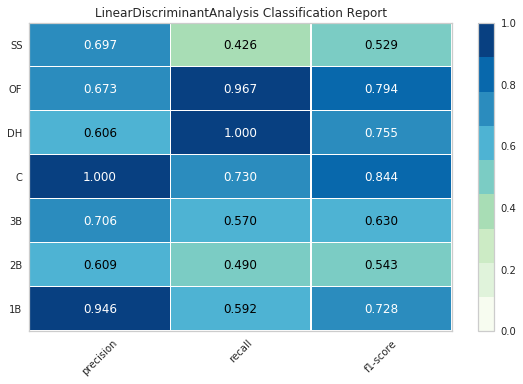

In [23]:
#Create LDA Object
clf = LinearDiscriminantAnalysis(n_components=2, priors=myPriors, solver='lsqr')
clf9 = LinearDiscriminantAnalysis(n_components=2, priors=myPriors, solver='svd')

clf.fit(X_train, y_train)
yhat2 = clf.predict(X_test)

#print("LDA Component Coefficients:", clf.coef_)
print(mt.classification_report(y_test, yhat2, target_names = ['1B', '2B', '3B', 'C', 'DH', 'OF', 'SS']))

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC
cm2 = ConfusionMatrix(clf, classes=['1B', '2B', '3B', 'C', 'DH', 'OF', 'SS'], cmap='GnBu')
cm2.fit(X_train, y_train)
cm2.score(X_test, y_test)
cm2.poof()

crpt = ClassificationReport(clf, classes=['1B', '2B', '3B', 'C', 'DH', 'OF', 'SS'], cmap='GnBu')
crpt.fit(X_train, y_train)
crpt.score(X_test, y_test)
crpt.poof()

#### Task 1.3 Random Forest
This is presented as one model.  However, two classifiers were tested in Task 1.3:  RandomForestClassfier and ExtraTreesClassifier.  This adds another layer of variation in addition to parameter and feature evaluation.  

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


player = pd.read_pickle("./analysisdata/player.pkl")
playerNoSal = pd.read_pickle("./analysisdata/playerNoSal.pkl")
playerScaled = pd.read_pickle("./analysisdata/playerScaled.pkl")
playerScaledNoSal = pd.read_pickle("./analysisdata/playerNoSalScale.pkl")

##### Main Random Forest Funtion
This function will be utilized by both the position classification and salary regression tasks.  The function performs cross validation, scoring and feature importance.

In [25]:
# Random Forest
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics as mt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

# Create Analysis Data Sets
X = playerScaled.drop(['Primary', 'playerID', 'yearID'], axis=1)
y = playerScaled['Primary']

def runModelCV(cv, clf, varImp = True):
    imps = list()
    accList = list()
    i = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]  
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accList.append(acc)
        print("Model", i, "Accuracy:", acc)
        imps.append(clf.feature_importances_)
        i += 1
    
    print("Mean Accuracy Across Models: ",np.mean(np.asarray(accList)))
    
    if(varImp):
        fig, ax = plt.subplots(figsize=(15,10))
        im = ax.imshow(imps)

        ax.set_xticks(np.arange(X.shape[1]))
        ax.set_yticks(np.arange(i - 1))
        ax.set_xticklabels(list(X))
        ax.set_yticklabels(np.arange(i) + 1)
        ax.set_xlabel("Feature")
        ax.set_ylabel("Model")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        ax.set_title("Comparison of Variable Importance Across CV Runs")
        fig.tight_layout()
        plt.show()
        

The modeling steps below investigate different stratified cross validation methods, classifiers and classifer parameters to obtain the optimal accuracy scores.

Model 1 Accuracy: 0.8785738311469896
Model 2 Accuracy: 0.8797510931718803
Model 3 Accuracy: 0.8760511268079381
Model 4 Accuracy: 0.8691557349478641
Model 5 Accuracy: 0.8841237806929028
Mean Accuracy Across Models:  0.877531113353515


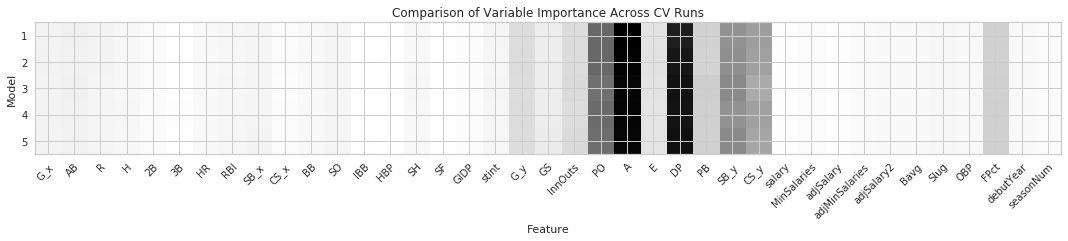

In [26]:
runModelCV(StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, train_size=0.7, random_state=0),
          RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

Model 1 Accuracy: 0.8845184064548663
Model 2 Accuracy: 0.8767019667170953
Model 3 Accuracy: 0.8746532156368222
Model 4 Accuracy: 0.8680292707544789
Model 5 Accuracy: 0.8828282828282829
Mean Accuracy Across Models:  0.877346228478309


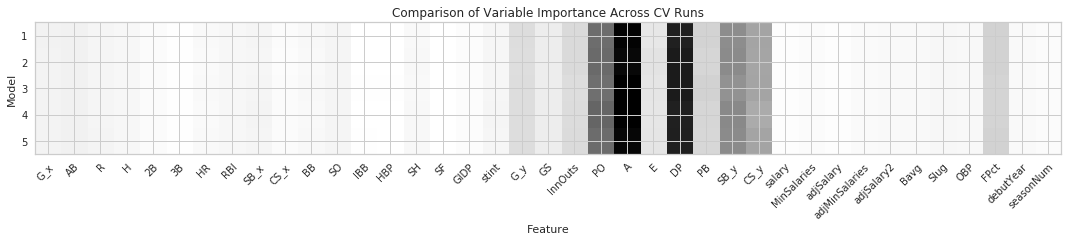

In [27]:
runModelCV(StratifiedKFold(n_splits=5),
          RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

Model 1 Accuracy: 0.8750420450723175
Model 2 Accuracy: 0.881096535486041
Model 3 Accuracy: 0.8753784056508577
Model 4 Accuracy: 0.8747056844937773
Model 5 Accuracy: 0.87941473259334
Mean Accuracy Across Models:  0.8771274806592668


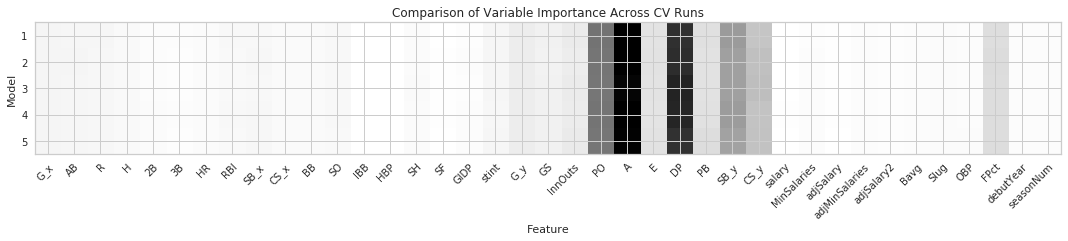

In [28]:
runModelCV(StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, train_size=0.7, random_state=0),
          ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

Model 1 Accuracy: 0.8885526979324256
Model 2 Accuracy: 0.8774583963691377
Model 3 Accuracy: 0.867843631778058
Model 4 Accuracy: 0.8710572798385062
Model 5 Accuracy: 0.8823232323232323
Mean Accuracy Across Models:  0.8774470476482719


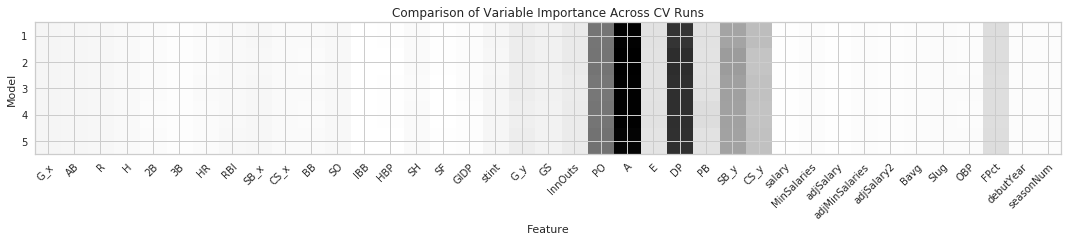

In [29]:
runModelCV(StratifiedKFold(n_splits=5),
          ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))


In [30]:
# Create Analysis Data Sets
X = player.drop(['Primary', 'playerID', 'yearID'], axis=1)
y = player['Primary']

Model 1 Accuracy: 0.8784056508577195
Model 2 Accuracy: 0.8799192734611504
Model 3 Accuracy: 0.875882946518668
Model 4 Accuracy: 0.8684830137907837
Model 5 Accuracy: 0.8836192398250925
Mean Accuracy Across Models:  0.877262024890683


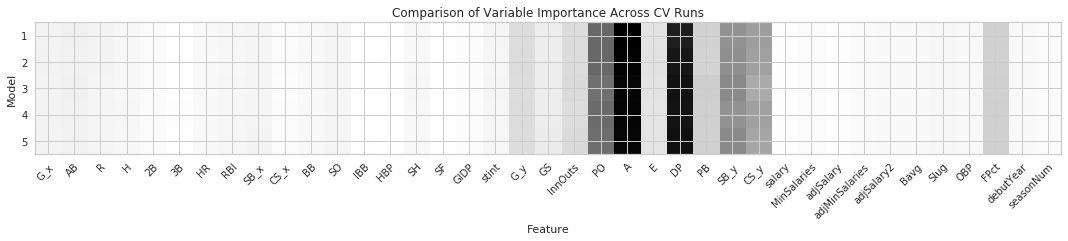

Model 1 Accuracy: 0.8847705496722138
Model 2 Accuracy: 0.8777105395864852
Model 3 Accuracy: 0.874905422446406
Model 4 Accuracy: 0.8660105980317941
Model 5 Accuracy: 0.8830808080808081
Mean Accuracy Across Models:  0.8772955835635414


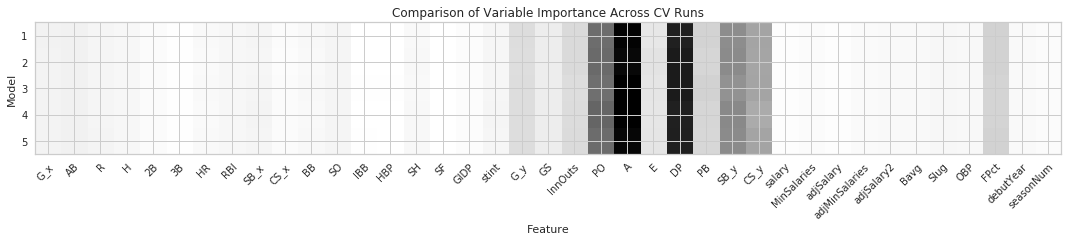

Model 1 Accuracy: 0.8755465859401278
Model 2 Accuracy: 0.8814328960645812
Model 3 Accuracy: 0.8752102253615877
Model 4 Accuracy: 0.8745375042045073
Model 5 Accuracy: 0.8795829128826101
Mean Accuracy Across Models:  0.8772620248906827


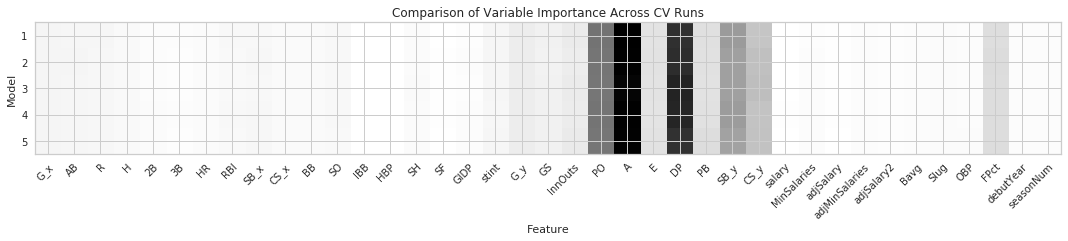

Model 1 Accuracy: 0.8885526979324256
Model 2 Accuracy: 0.8769541099344428
Model 3 Accuracy: 0.867843631778058
Model 4 Accuracy: 0.8715619480191774
Model 5 Accuracy: 0.8823232323232323
Mean Accuracy Across Models:  0.8774471239974672


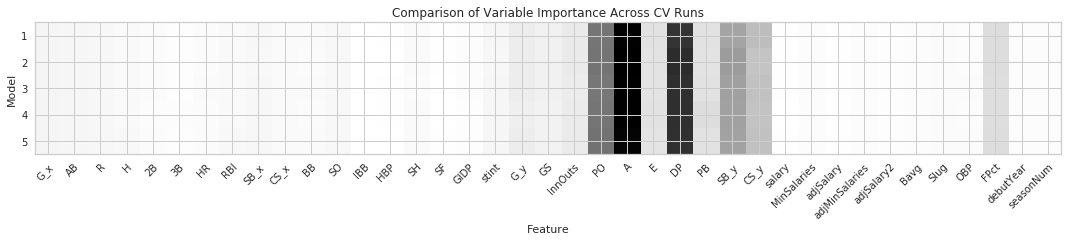

In [31]:
runModelCV(StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, train_size=0.7, random_state=0),
          RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

runModelCV(StratifiedKFold(n_splits=5),
          RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

runModelCV(StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, train_size=0.7, random_state=0),
          ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

runModelCV(StratifiedKFold(n_splits=5),
          ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

### Task 2:  Salary Regression
The salary regression task will predict player salaries per season.  The three models developed for this task are Random Forest, ElasticNet and KNN.  The data set present possible complications concerning salary prediction for players who did not start the year on a major league roster.  As discussed in the data preparation section, league minimum salaries will be used to assist with these instances.  For regression tasks, non-stratified cross validation methods will be utilized.  

#### Task 2.1 - Random Forest Regression
This is presented as one model.  However, two classifiers were tested in Task 1.3:  RandomForestClassfier and ExtraTreesClassifier.  This adds another layer of variation in addition to parameter and feature evaluation.  

In [33]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Create Analysis Data Sets
X = player.drop(['salary', 'adjSalary', 'adjSalary2', 'playerID'], axis=1)
y = player['adjSalary2']

X = pd.get_dummies(X, prefix='is_')

The Random Forest Regression uses concise code to explore different classifiers and classifier parameters to find the best regression model.  The R-squared value is presented to measure the quality of the model.

Model 1 Accuracy: 0.6871949523492139
Model 2 Accuracy: 0.694120682509025
Model 3 Accuracy: 0.6778886351932845
Model 4 Accuracy: 0.7058210997529758
Model 5 Accuracy: 0.6772337142276179
Mean Accuracy Across Models:  0.6884518168064234


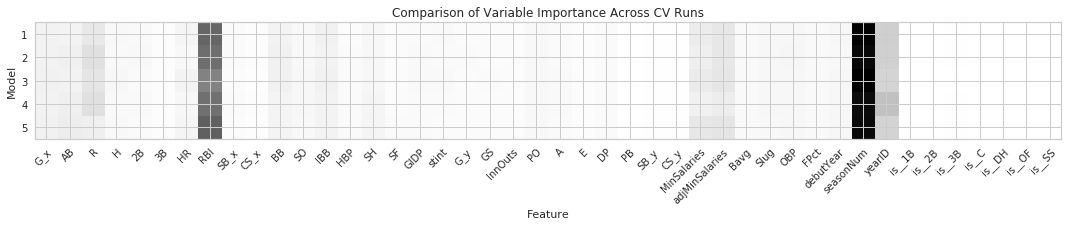

In [34]:
runModelCV(KFold(n_splits=5, shuffle=True, random_state=None),
          RandomForestRegressor(n_estimators=400, max_depth=None, min_samples_split=2, n_jobs=-1))

Model 1 Accuracy: 0.6805477530802745
Model 2 Accuracy: 0.720170326942551
Model 3 Accuracy: 0.7077282960740323
Model 4 Accuracy: 0.6650157035416954
Model 5 Accuracy: 0.690751745606524
Mean Accuracy Across Models:  0.6928427650490155


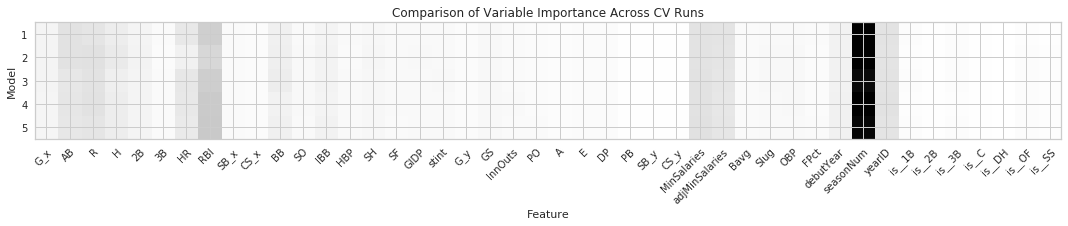

In [35]:
runModelCV(KFold(n_splits=5, shuffle=True, random_state=None),
          ExtraTreesRegressor(n_estimators=400, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1))

Model 1 Accuracy: 0.6813937528520531
Model 2 Accuracy: 0.6799026072832499
Model 3 Accuracy: 0.7130495366453773
Model 4 Accuracy: 0.6786089051414306
Model 5 Accuracy: 0.6760045384503488
Mean Accuracy Across Models:  0.685791868074492


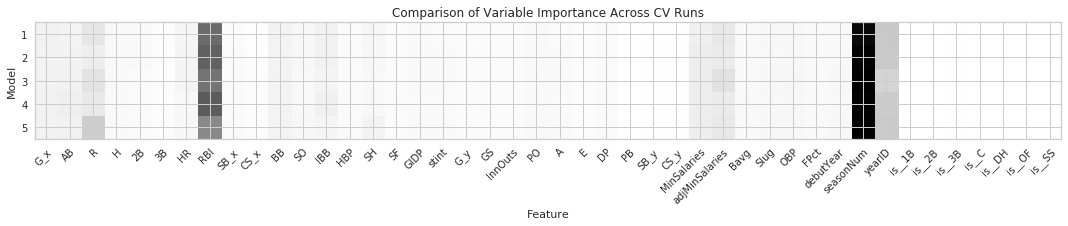

Model 1 Accuracy: 0.6859832104766245
Model 2 Accuracy: 0.7015661869828327
Model 3 Accuracy: 0.6933757920877195
Model 4 Accuracy: 0.706107141004356
Model 5 Accuracy: 0.6974692906540889
Mean Accuracy Across Models:  0.6969003242411244


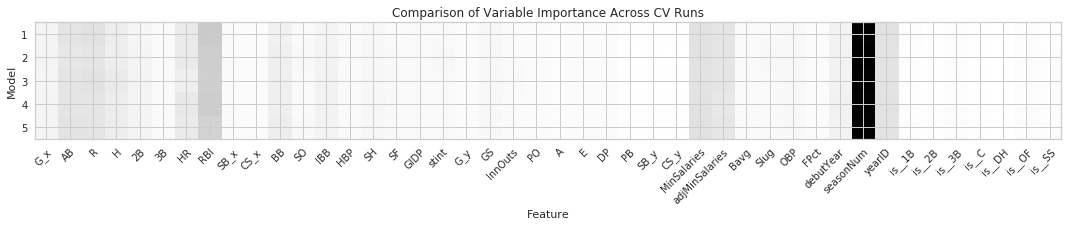

In [37]:
# Create Analysis Data Sets
X = playerScaled.drop(['salary', 'adjSalary', 'adjSalary2', 'playerID'], axis=1)
y = playerScaled['adjSalary2']

X = pd.get_dummies(X, prefix='is_')

runModelCV(KFold(n_splits=5, shuffle=True, random_state=None),
          RandomForestRegressor(n_estimators=400, max_depth=None, min_samples_split=2, n_jobs=-1))

runModelCV(KFold(n_splits=5, shuffle=True, random_state=None),
          ExtraTreesRegressor(n_estimators=400, max_depth=None, min_samples_split=2, random_state=0, n_jobs=-1))

#### Task 2.2 - ElasticNet Salary Regression

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import yellowbrick as yb
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn import metrics as mt

import warnings
warnings.filterwarnings('ignore')

player = pd.read_csv('./data/player.csv')
playerNoSal = pd.read_csv('./data/playerNoSal.csv')
playerScale = pd.read_csv('./data/playerscale.csv')
playerNoSalScale = pd.read_csv('./data/playerNoSalscale.csv')

playerNoSalG = playerNoSal[playerNoSal.G_x > 30]
playerG = player[player.G_x > 30]

### ElasticNet Feature Reduction

#### Drop Columns with Limited Predictive Ability for ElasticNet Model

In [19]:
player = player.drop(["Unnamed: 0", "Annual Average", "AnnualPercentChange", "Mult2017", "MinSalaries", "adjSalary", "adjMinSalaries", "salary", "playerID"], axis=1)
playerNoSal = playerNoSal.drop(["Unnamed: 0", "Annual Average", "AnnualPercentChange", "Mult2017", "MinSalaries", "adjSalary", "adjMinSalaries", "salary", "playerID"], axis=1)

playerG = playerG.drop(["Unnamed: 0", "Annual Average", "AnnualPercentChange", "Mult2017", "MinSalaries", "adjSalary", "adjMinSalaries", "salary", "playerID"], axis=1)
playerNoSalG = playerNoSalG.drop(["Unnamed: 0", "Annual Average", "AnnualPercentChange", "Mult2017", "MinSalaries", "adjSalary", "adjMinSalaries", "salary", "playerID"], axis=1)
#playerNoSalScale = playerNoSalScale.drop(["MinSalaries", "adjSalary", "adjMinSalaries", "salary"], axis=1)
print(playerNoSal.info())
print(playerNoSal.describe())
print(playerNoSalG.info())
print(playerNoSalG.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13682 entries, 0 to 13681
Data columns (total 37 columns):
yearID        13682 non-null int64
G_x           13682 non-null int64
AB            13682 non-null int64
R             13682 non-null int64
H             13682 non-null int64
2B            13682 non-null int64
3B            13682 non-null int64
HR            13682 non-null int64
RBI           13682 non-null float64
SB_x          13682 non-null float64
CS_x          13682 non-null float64
BB            13682 non-null int64
SO            13682 non-null float64
IBB           13682 non-null float64
HBP           13682 non-null float64
SH            13682 non-null float64
SF            13682 non-null float64
GIDP          13682 non-null float64
stint         13682 non-null float64
G_y           13682 non-null float64
GS            13682 non-null float64
InnOuts       13682 non-null float64
PO            13682 non-null float64
A             13682 non-null float64
E             13682 n

#### ElasticNet PreModel Data Validation
The inflation adjusted salary plotted below is heavily right skewed.  The ElasticNet model requires a normally distributed response variable to function correctly.  The log transformed adjusted salary plot shows a fairly normalized distribution of adjusted salary.  

Text(0.5,1,'Log Transformed')

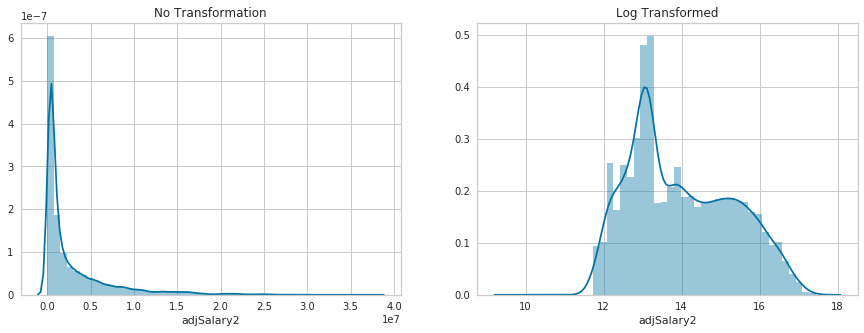

In [65]:
fig, ax =plt.subplots(1,2, figsize=(15,5))
sns.distplot(playerNoSal.adjSalary2, ax=ax[0]).set_title("No Transformation")

#plot log transformed adjSalary2
logas2 = playerNoSal['adjSalary2'].apply(np.log)
sns.distplot(logas2, ax=ax[1]).set_title("Log Transformed")

In [21]:
from sklearn.model_selection import train_test_split

#Set Explanatory and Response
#X = playerNoSal
X = playerNoSalG
X = X.drop(["adjSalary2"], axis=1)
#Convert Position to Integer
X['Primary'] = X['Primary'].map({'1B':3, '2B':4, '3B':5, 'C':2, 'SS':6, 'OF':7, 'DH':10})
XDF = X

##Log Transformations
#colnames = X.columns
#
#for c in colnames:
#    if (c != "yearID" and c != "Primary" and c != "G_x" and c != "G_y"):
#        X[c] = X[c].apply(np.log)
#
#print(X.describe())
#XDFLog = X

X = X.values

print(type(X))

#y = playerNoSal.adjSalary2
y = playerNoSalG.adjSalary2
y = y.apply(np.log)
yDF = y
y = y.values
yVal = y

yhat = np.empty(y.shape, dtype=float)

#Create Train Test Split
X_train, X_test, y_train, y_test = train_test_split(XDF, y, test_size=0.2, random_state=42)

<class 'numpy.ndarray'>


#### ElasticNet Parameter Selection
GridSearchCV is used to assist with determining the optimal combination of alpha level and L1 Ratio for the ElasticNet model.  Ten fold cross validation is used for this task.  Mean Squared Error is the measurement used to score the various combinations identified by GridSearchCV.

In [22]:
myAlphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
myL1R = [0, 1]
parms = {'alpha': [myAlphas], 'l1_ratio': [myL1R]}
parmGrid = list(ParameterGrid(parms))
print(parmGrid)

gscv = GridSearchCV(estimator=ElasticNet(), n_jobs=-1, cv=10, verbose=1, param_grid = parmGrid, scoring='mean_squared_error')
gscv.fit(X_train, y_train)

[{'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'l1_ratio': [0, 1]}]
Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   40.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 220 out of 220 | elapsed:  2.9min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=10,
       param_grid=[{'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'l1_ratio': [0, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='mean_squared_error', verbose=1)

The GridSearchCV procedure identified an alpha level of 0 with L1 Ratio of 0 as the best model for this data set.

In [23]:
print("Best Estimator:", gscv.best_estimator_)
print("Best Parameters:", gscv.best_params_)
print("Best Score:", gscv.best_score_)

Best Estimator: ElasticNet(alpha=0, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Best Parameters: {'alpha': 0, 'l1_ratio': 0}
Best Score: -0.6041961208368106


#### ElasticNet Recursive Feature Elimination

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


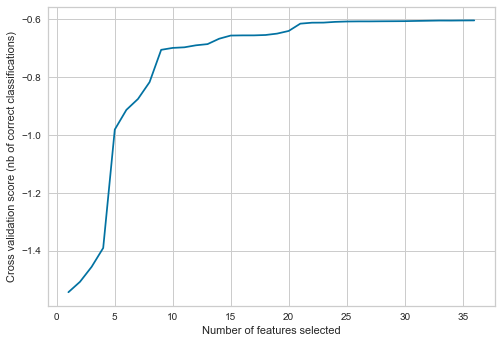

Optimal number of features : 36


In [24]:
from sklearn.feature_selection import RFECV


#Create Train Test Split
X_train, X_test, y_train, y_test = train_test_split(XDF, y, test_size=0.2, random_state=42)

rfecv = RFECV(estimator=gscv.best_estimator_, step=1, cv=10, scoring='mean_squared_error', verbose=0)
#rfecv = RFECV(estimator=gscv.best_estimator_, step=1, cv=10, scoring='r2', verbose=0)
rfecv.fit(X_train, y_train)
#print(rfecv.n_features_)
print(rfecv.ranking_)
#print(rfecv.support_)

#plot features selected with cross validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print("Optimal number of features : %d" % rfecv.n_features_)

In [25]:
#Drop columns based on RFECV rankings
droplist= []

for i in range(len(rfecv.ranking_)):
    if (rfecv.ranking_[i] != 1):
        droplist.append(i)

print(droplist)


[]


In [26]:
XDF = XDF.drop(droplist)

#### Salary Prediction - ElasticNet
Both the R-square and mean squared error are presented for the ElasticNet Model.

In [27]:
enet = ElasticNet(alpha=0, l1_ratio=0)
enet.fit(X_train, y_train)
print("R^2:", enet.score(X_test, y_test))
yhatE = enet.predict(X_test)
print("MSE:", mt.mean_squared_error(y_test, yhatE))

R^2: 0.6489042226631013
MSE: 0.6032170762228258


#### Feature Significance - ElasticNet

36 features, reduction of 0.00%


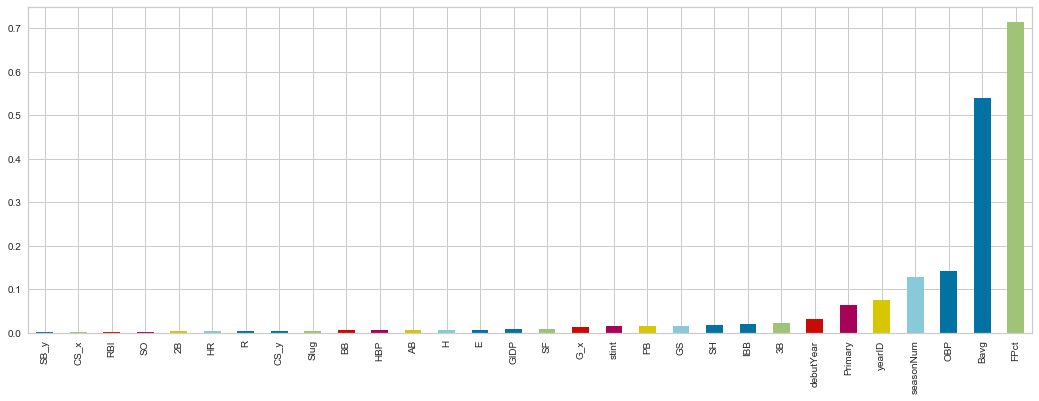

In [28]:
Xfeat = pd.DataFrame(X_train)

feature_importance = pd.Series(index = Xfeat.columns, data = np.abs(enet.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (18,6))

#### Task 2.3 - KNN

In [38]:
import numpy as np
import pandas as pd
df = pd.read_pickle("./analysisdata/player.pkl")
print('Dataframe Size:',df.shape)
print('Dataframe Null values:',df.isnull().values.ravel().sum())
#print ('Number of unique classes:\n',df.nunique())

Dataframe Size: (19820, 42)
Dataframe Null values: 0


In [50]:
# Printing Head and Tail of Dataset
df.iloc[np.r_[0:6, -6:0]]

,G_x,AB,R,H,2B,3B,HR,RBI,SB_x,CS_x,...,adjSalary2,Bavg,Slug,OBP,FPct,debutYear,seasonNum,yearID,playerID,Primary
0,1,1,0,0,0,0,0,0.0,0.0,0.0,...,276800.0,0.000000,0.000000,0.000000,1.000000,2001,1,2001,abadan01,1B
1,9,17,1,2,0,0,0,0.0,0.0,1.0,...,399600.0,0.117647,0.117647,0.210526,0.972973,2001,3,2003,abadan01,1B
2,5,3,0,0,0,0,0,0.0,0.0,0.0,...,397632.0,0.000000,0.000000,0.400000,0.000000,2001,6,2006,abadan01,DH
3,19,38,8,10,1,0,1,2.0,0.0,0.0,...,229050.0,0.263158,0.368421,0.263158,1.000000,1997,1,1997,abbotje01,OF
4,89,244,33,68,14,1,12,41.0,3.0,3.0,...,263200.0,0.278689,0.491803,0.298450,0.970588,1997,2,1998,abbotje01,OF
5,17,57,5,9,0,0,2,6.0,1.0,1.0,...,375105.0,0.157895,0.263158,0.222222,0.961538,1997,3,1999,abbotje01,OF
19814,36,92,10,18,4,1,1,8.0,0.0,1.0,...,180286.0,0.195652,0.293478,0.226804,1.000000,1991,4,1994,zupcibo01,OF
19815,81,190,16,48,8,1,0,4.0,2.0,0.0,...,136740.0,0.252632,0.305263,0.310680,0.972696,1982,4,1985,zuvelpa01,2B
19816,21,48,2,4,1,0,0,2.0,0.0,0.0,...,134160.0,0.083333,0.104167,0.169811,0.965517,1982,5,1986,zuvelpa01,SS
19817,14,34,2,6,0,0,0,0.0,0.0,0.0,...,134875.0,0.176471,0.176471,0.176471,1.000000,1982,6,1987,zuvelpa01,2B


In [51]:
#Drop Variables with no predictive ability
df.drop(['MinSalaries', 'salary', 'adjSalary', 'adjMinSalaries','playerID'], inplace=True, axis=1)

In [52]:
#Creating Dummy variables for categorical variable 'Primary' positions
df2 = pd.get_dummies(df.Primary,prefix='Prim', prefix_sep='_')
df = df.join(df2, how='inner')
df.drop(['Primary'], axis=1, inplace=True)

In [53]:
#Set minimum games at 30
df = df[df['G_x'] > 30]
df = df.reset_index(drop=True)
df.iloc[np.r_[0:6, -6:0]]

,G_x,AB,R,H,2B,3B,HR,RBI,SB_x,CS_x,...,debutYear,seasonNum,yearID,Prim_1B,Prim_2B,Prim_3B,Prim_C,Prim_DH,Prim_OF,Prim_SS
0,89,244,33,68,14,1,12,41.0,3.0,3.0,...,1997,2,1998,0,0,0,0,0,1,0
1,80,215,31,59,15,1,3,29.0,2.0,1.0,...,1997,4,2000,0,0,0,0,0,1,0
2,101,345,41,86,17,3,9,33.0,3.0,0.0,...,1993,2,1994,0,0,0,0,0,0,1
3,120,420,60,107,18,7,17,60.0,4.0,3.0,...,1993,3,1995,0,0,0,0,0,0,1
4,109,320,37,81,18,7,8,33.0,3.0,3.0,...,1993,4,1996,0,0,0,0,0,0,1
5,94,252,35,69,18,2,6,30.0,3.0,1.0,...,1993,5,1997,0,1,0,0,0,0,0
14764,124,387,52,97,25,0,25,64.0,1.0,0.0,...,2013,5,2017,0,0,0,1,0,0,0
14765,124,392,46,108,19,1,3,43.0,2.0,2.0,...,1991,2,1992,0,0,0,0,0,1,0
14766,141,286,40,69,24,2,2,26.0,5.0,2.0,...,1991,3,1993,0,0,0,0,0,1,0
14767,36,92,10,18,4,1,1,8.0,0.0,1.0,...,1991,4,1994,0,0,0,0,0,1,0


In [54]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')

# create variables we are more familiar with
y = df.adjSalary2
X = df.drop(['adjSalary2'], axis=1)

#### KNN Regression Parameter Optimization with GridSearch

K-Nearest Neighbor (KNN) is best known for classification but it can also be used for regression (KNNReg). KNNReg estimates the function f(x) using the average of all the responses in the training observations.  
Similar to KNN, parameter selections are critical to the performance of KNNReg; therefore, substantial time and effort was put forth to fully investigate the optimal parameters. Preprocessing of dataset is also critical.

##### Parameter Analysis:

*Algorithms:*  Algorithm used to compute the nearest neighbors can be ‘auto’matically determine the most appropriate algorithm to use for the given dataset/parameters, so it was left as default in our GridSearch

##### GridSearch Parameters:

*n_neighbors:* 	Number of neighbors to use in the analysis.  Preliminary analyses were conducted to find a desired range of for number of neighbors.  From these analyses, it was determined that the optimal number of neighbors is below 15.

*Leaf_size:*  	The leaf size was adjusted, using: 5, 10, and 30 as the parameters.  While there is an over-head penalty with using smaller leaves, accuracy may increase, so we will use it in our Grid Search.

*Metric:*		How distance is measure between datapoints can be adjusted.  The 2 options chosen were ‘minkowski’ and ‘euclidean’.

*Weights:* 	Both uniform and distance were looked at.  ‘Uniform’ weight-all neighboring points get equal weight.  ‘Distance’ weights points by the inverse of their distance.


*Predictor Variables:*  
Many of the predictor variable have different scaling, so to ensure all variables were treated equally in the analysis, all predictor variables are scaled to have a mean of 0 and Standard deviation of 1.

In [55]:
# Scaling training variables
scl = StandardScaler()
X = scl.fit_transform(X)

from sklearn.model_selection import train_test_split
#Create Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Create K-Fold quantity
cv = 10

#KNN regressor 10-fold cross-validation 
from sklearn.neighbors import KNeighborsRegressor

RegEstimator = KNeighborsRegressor()
parameters = { 'n_neighbors':[3,5,15,30], 'weights': ['uniform','distance'],'leaf_size': [5,10,30], 'metric': ['euclidean','minkowski']}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
KNNGridSearch = GridSearchCV(estimator=RegEstimator, n_jobs=8, verbose=1, param_grid=parameters, cv=cv, scoring='r2')

#Perform hyperparameter search to find the best combination of parameters for our data
KNNGridSearch.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 15.7min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 31.3min
[Parallel(n_jobs=8)]: Done 480 out of 480 | elapsed: 33.7min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'leaf_size': [5, 10, 30], 'n_neighbors': [3, 5, 15, 30], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'minkowski']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

The GridSearch algorithm determined the following optimal paramters for K-Neighbors Regressor Algorithn.

*Leaf-Size:* 5  
*Number of Neighbors:* 15  
*Distance Metric:* Euclidean  
*Weights:* distance  

*R2:*  0.497

An R2 value of 49.7% was achieved with the optimal model. While not optimal, it does show that this model explains approximately 50% of the variation of salaries of MLB players.  Other algorithms or additional parameters should be looked into, to help improve the predictive performance of this model.

*Note:*  It is interesting to note that the optimal parameters for KNN Classificatoin are very different from KNN Regression. Leaf_size, Distance_Metric, and weights are all different.  This is further evidence that parameter tuning is critical to performance of KNN algorithms.

In [56]:
print("Best Estimator:", KNNGridSearch.best_estimator_)
print("Best Parameters:", KNNGridSearch.best_params_)
print("Best Score:", KNNGridSearch.best_score_)


Best Estimator: KNeighborsRegressor(algorithm='auto', leaf_size=5, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='distance')
Best Parameters: {'leaf_size': 5, 'metric': 'euclidean', 'weights': 'distance', 'n_neighbors': 15}
Best Score: 0.49687191858820035


In [57]:
from sklearn.model_selection import cross_val_score
reg_knn = KNeighborsRegressor(n_neighbors=15, weights='distance', metric='euclidean',algorithm='auto',leaf_size=5)
scores = cross_val_score(reg_knn, X, y, scoring='r2',cv=cv)
print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R2: 0.44 (+/- 0.09)


## Modeling and Evaluation 4

This section will compare the models developed for each task using visualizations and measurements generated during model testing.  The position classification task will focus on accuracy scores.  The salary regression task will compare R-Squared scores.  Model advantages will be discussed in an upcoming section.

**Position Classification**
The following code block allows us to compare models in a controlled method.  The code will print accuracy scores using a consistent stratified cross validation method, number of splits and scoring.  A boxplot will also be created to help with visual inspection of the results.

In [31]:
# evaluate each model in turn
def ME4Analysis(fmodels, fscoring, fX, fy):
    results = []
    names = []
    #scoring = 'accuracy'
    for name, model in fmodels:
        if (fscoring == 'accuracy'):
            skf = StratifiedKFold(n_splits=10, random_state=seed)
        else:
            skf = 10
        cv_results = model_selection.cross_val_score(model, fX, fy, cv=skf, scoring=fscoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    sns.boxplot(x=names, y=results, palette="Set1")
    plt.show()
    
    return [names, results]

LDA: 0.726138 (0.007998)
KNN: 0.706053 (0.008906)
RF: 0.878406 (0.008234)
RFET: 0.879264 (0.010007)


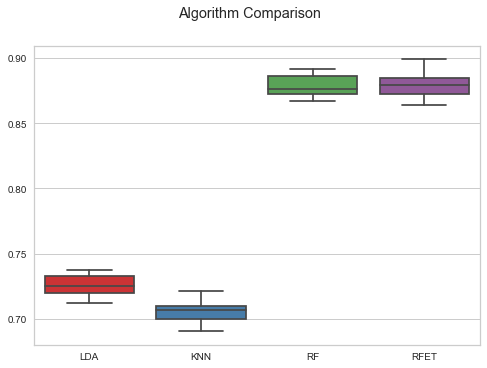

In [32]:
## Credit To:  
#### https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import model_selection

seed = 7
# prepare models
class_models = []
class_models.append(('LDA', LinearDiscriminantAnalysis(n_components=2, priors=myPriors, solver='lsqr')))
class_models.append(('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski', 
                                           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                                           weights='uniform')))
class_models.append(('RF', RandomForestClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1)))
class_models.append(('RFET', ExtraTreesClassifier(n_estimators=600, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1)))

classModelResults = ME4Analysis(class_models, 'accuracy', XT1, yT1)

The accuracy scores and boxplot clearly show the two random forest models are superior to LDA and KNN.  The model scores for Random Forest and Extra Trees are almost identical.  The Random Forest model does appear to procude a slightly tighter distribution will slightly less extreme outliers.  

**Salary Regression**
The Salary Regression analysis will leverage the same function used to produce the analysis for the position classification.  The models will be scored using the R-squared values and boxplots will be generated for visual insepction.

ElasticNet: 0.643216 (0.030344)
KNN: 0.233546 (0.039777)
RF: 0.769707 (0.023938)
RFET: 0.766085 (0.025434)


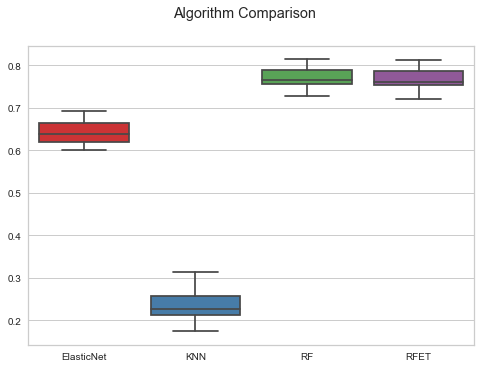

In [34]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

seed = 7
# prepare models
reg_models = []
reg_models.append(('ElasticNet', ElasticNet(alpha=0, l1_ratio=0)))
reg_models.append(('KNN', KNeighborsRegressor(n_neighbors=15, weights='distance', metric='euclidean',algorithm='auto',leaf_size=5)))
reg_models.append(('RF', RandomForestRegressor(n_estimators=400, max_depth=None, min_samples_split=2, n_jobs=-1)))
reg_models.append(('RFET', ExtraTreesRegressor(n_estimators=400, max_depth=None, min_samples_split=2, random_state=0,  n_jobs=-1)))

regModelResults = ME4Analysis(reg_models, 'r2', XDF, yDF)

Once again, The Random Forest and Extra Trees regressors are virtually identical.  Additionally, further tuning of the ElasticNet model could yied could results as well.  Alternatively, the KNN model is not a good fit for this task.  The KNN regressor is expensive in terms of time and CPU requirements and produces inferior results.  In the end, either the Random Forest or the Extra Trees models can be used to predict player salary with a reasonable level of confidence.  

## Modeling and Evaluation 5

The random forest models demonstrated clear superiority in player classification and the best performance in the salary regression modeling. Model accuracy is obviously a clear advantage when selecting any model over another. To confirm that the models perform differently we calculated 95% CI for the difference in accuracy between each pairwise comparison of models from a 10 K cross validation split. The differences in accuracies across between the models was compared using the same subsets of data making for a more informative comparison.

In [40]:
from math import sqrt
from scipy import stats
# Iterate Pairwise through models and calculate CI
def modelCiComp(modelResults):
    for i in range(len(classModelResults[0])):
        for j in range(i+1, len(classModelResults[1])):
            m1Acc = classModelResults[1][i]
            m2Acc = classModelResults[1][j]
            d = m1Acc - m2Acc
            dBar = np.mean(d)
            v = np.var(d)
            ci = (1/sqrt(len(m1Acc)))*stats.t.ppf(q = .975, df = len(m1Acc) - 1)*sqrt(v)
            ci = "[" + str(round(dBar - ci, 5)) + ", " + str(round(dBar + ci, 5)) + "]"
            print("95% CI for", classModelResults[0][i], "vs", classModelResults[0][j], "=", ci)


**Position Classification Model CI Comparison**

The results of the 95% confidence interval confirm that the accuracy of the random forest models is statistically different from the KNN and LDA models. Additionally, LDA outperformed KNN. Also, as expected from earlier evaluation of plots, the CI analysis confirms that the RF model and the extra trees models do not perform statistically differently than each other (zero is included int he 95% CI)

In [41]:
modelCiComp(classModelResults)

95% CI for LDA vs KNN = [0.01574, 0.02443]
95% CI for LDA vs RF = [-0.15876, -0.14578]
95% CI for LDA vs RFET = [-0.15903, -0.14722]
95% CI for KNN vs RF = [-0.17922, -0.16548]
95% CI for KNN vs RFET = [-0.17992, -0.16651]
95% CI for RF vs RFET = [-0.00431, 0.00259]


**Salary Regression Model CI Comparison**

The results of the 95% confidence interval test for differences between the salary regression models mirror closely those from the classification models. The two forest-based models performed the best and not significantly different from each other and the LDA outperformed the KNN model.

In [42]:
modelCiComp(regModelResults)

95% CI for LDA vs KNN = [0.01574, 0.02443]
95% CI for LDA vs RF = [-0.15876, -0.14578]
95% CI for LDA vs RFET = [-0.15903, -0.14722]
95% CI for KNN vs RF = [-0.17922, -0.16548]
95% CI for KNN vs RFET = [-0.17992, -0.16651]
95% CI for RF vs RFET = [-0.00431, 0.00259]


In addition to accuracy, the random forest models also have the additional advantages. The bagging method makes random forests less dependent on feature selection and hyper parameters. Random forest models are also uniquely suited for variable importance comparison since only a subset of variables per tree in the forest.

Lastly, random forest models have the advantage of relative simplicity when to comes to conceptualizing and explaining the models to a non-technical person (think C-suite executives). Most people can grasp generally the idea of picking a subset of data and variables many times then combing and comparing the results across all the models. That is a much easier concept to grasp than something like infinite dimensions with SVM or reducing dimensionality of data with PCA.

All these advantages and the relative accuracy of the models make random forests and excellent candidate model for this analysis.

## Modeling and Evaluation 6

This section will determine the most important features in each model task using visualizations and measurements generated during modeling. 

### Important Attributes for Position Classification

The modeling techniques used for the position classification task were KNN, LDA, and random forest classification models. KNN uses neighboring points classifications; therefore, feature importance is not a valid measure. Linear Discriminant Analysis is dimensionality reduction technique. As a result, interpreting the most significant attributes in the model is very complicated, since modeling variables are combinations of the original variables. So in order to determine the most important features in classifying player's positions, we will examine the feature importance plot from the random forest models. 

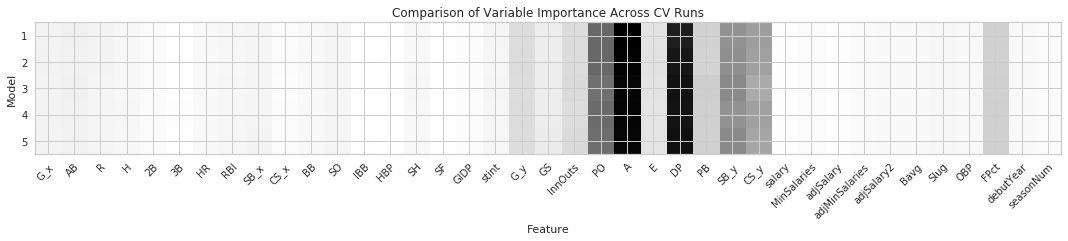

In [7]:
from IPython.display import Image
Image(filename = "./Feature Importance/RF1.png")

**Most Important Features:**

1. DP, number of double plays
2. A, number of assists
3. PO, number of putouts
4. SB_y, number of stolen bases
5. CS_y, number of times caught stealing
6. FPct, fielding percentage

The majority of the most important attributes found above are defensive statistics. This makes intuitive sense as the player's positions are often determined by how well they can field the ball, throw the ball, etc. A player's offensive stats, such as number of homeruns, does play a factor in whether or not a player is a first baseman or not. If a player is better at fielding, then they are more likely to be in the infield. As expected, SB_y (bases stolen by the opposition) and CS_y (caught opposition stealing) are significant position classifiers as they are specific to players who play catcher.  

Interestingly, offensive statistics do not play a major role in classifying players by position.  Conventional baseball wisdom would suggest ShortStops, second basemen and catchers are allowed to be lesser offensive players because their defensive skills are critical to a team's sucess.  This revelation could suggest the offensive production by position is no longer drasticall different by position.  This may warrant futher research in a different study.

### Important Attributes for Salary Regression

The modeling techniques used for the salary prediction task were random forest regression, elastic net regression and KNN models. Once again, we cannot determine the most important attributes from the KNN model. Therefore, we will determine the most features from the random forest and elastic net regression models.

#### Random Forest Feature Importance

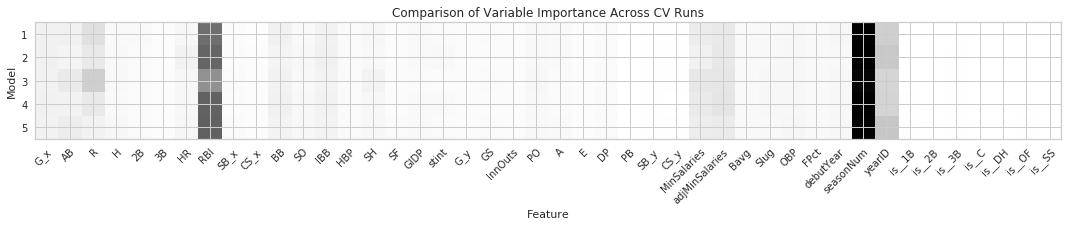

In [11]:
Image(filename = "./Feature Importance/RFSalary1.png")

Most Important Features in Random Forest:
1.  Season Number
2.  Debut Year
3.  RBI, number of runs batted in
4.  HR, number of homeruns
5.  YearID

#### Elastic Net Feature Importance

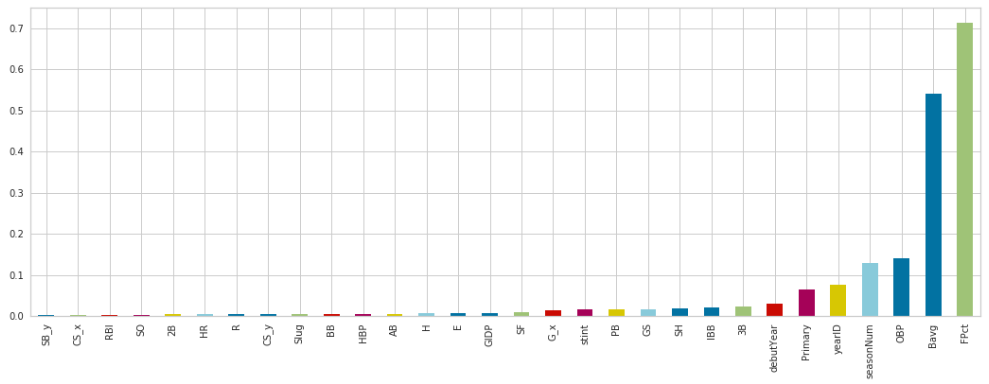

In [12]:
Image(filename = "./Feature Importance/ElasticNet.png")

Most Important Features in Elastic Net:
1.  FPct, fielding percentage
2.  Bavg, batting average
3.  OBP, on-base percentage
4.  Season Num
5.  yearID
6.  Primary, player's position
7. Debut year

Both the random forest and elastic net regression models determined the season number, debut year, and year ID are some of the most important attribute features. These attributes are all year identifiers; this makes sense as a player plays longer in the major league his salaries tend to increase over the course of his career.  The random forest and elastic net models selected mostly tenure and offensive stats.  However, the single most important feature, as identifyed by the ElasticNet model is fielding percentage (FPct).  Generally, player contracts are largely based on their offensive abilities.  Eventhough the ElasticNet model did not produce results comparable to the Forest Models, this could suggest complete offensive and defensive players earn more than those who are mostly offensive weapons.  

## Deployment

The position classification and salary prediction models are most useful for Major League baseball teams, but could potentially be used for other baseball organizations. The position classification models can help teams decide where a player might perform best on the field. Running a player's statistics through the model could help determine the optimal position that fits the player's abilities. This would optimize player's abilities, which would lead to better performances and results across the team. The most useful model to classify a player's position would be the random forest model. This model had an accuracy of 87.84% and is relatively easy to understand compared to the other models. This model's accuracy could be improved by adding variables such as longest distance thrown, pitching speed and dominant throwing hand. 
   
The salary prediction model would help determine how much a team should spend on a player. This would help cut excessive spending on players or be used by players to determine how much they are worth. Like the position classification model, the random forest regression would was the most accurate, at 74.3% and the most easily interpretable. The model's accuracy could be improved by adding additional variables such as popularity (such as number of times appeared in the news), number picked in the draft, and last salary earned.  
    
For the models to be used by interested parties, the model needs to be made available in the software the team's analysts use. One potential way for the position classification to be distributed would be by creating a restful API in python, then using a lambda function hosted in AWS to trigger an EC2 instance. This model would need to be updated every season for best results. For the salary prediction model, batch predictions might be the best method. This could be deployed using tensorflow and a cloud machine learning engine. 
    
If implemented, the position classification model's worth could be determined by player's defensive efficiencies before and after a position change occured due to the model. Additionally, if a team implemented the position model for every player, the team's overall defensive statistics should be better than before the model was implemented. The salary prediction model's worth is a little harder to measure. If it was used by players, then it could be utilized by agents to determine the maximum contract amount a team be willing to sign.  This model would need to be updated every season for best results.

## Exceptional Work

Even though in the sections above we have concluded that the random forest based models are better at classification and regression compared to LDA and It may be the case that LDA or KNN are better at predicting certain types of classes better in some instances. To try and account for this we decided to attempt to use a voting ensemble method to combine the classifications across the models. The basic premise of this approach is that each model will make a prediction for each instance and they will then "vote" on the classification between themselves.

We will try both hard voting (majority rules) and soft voting (average probability).

In [18]:
from sklearn.ensemble import VotingClassifier
player = pd.read_pickle("./analysisdata/player.pkl")

# Create Analysis Data Sets
X = player.drop(['Primary', 'playerID', 'yearID'], axis=1)
y = player['Primary']

**Hard Voting Ensemble**

In [19]:
vclf = VotingClassifier(class_models,  voting='hard')
acc = model_selection.cross_val_score(vclf, X, y, cv=StratifiedKFold(n_splits=10, random_state=seed), scoring="accuracy")
print(acc)
print("Mean Accuracy:", np.mean(acc))

[0.88558468 0.88004032 0.87096774 0.87247984 0.87487386 0.83400605
 0.8728557  0.86622918 0.86862052 0.85439838]
Mean Accuracy: 0.868005627602974


**Soft Voting Ensemble**

In [20]:
vclf = VotingClassifier(class_models,  voting='hard')
acc = model_selection.cross_val_score(vclf, X, y, cv=StratifiedKFold(n_splits=10, random_state=seed), scoring="accuracy")
print(acc)
print("Mean Accuracy:", np.mean(acc))

[0.88558468 0.88004032 0.87096774 0.87247984 0.87487386 0.83400605
 0.8728557  0.86622918 0.86862052 0.85439838]
Mean Accuracy: 0.868005627602974


In [17]:
import warnings
warnings.filterwarnings("ignore")

Based on the results of the voting ensemble it does not appear that there is much benefit from the voting approach in this situation. The models do perform similarly to the best performing models, but with more overhead since it requires running each of the models. The lack of improvement also suggests that the models generally agree on classifications and there is no model which adds better estimates in specific situations. In fact, with hard voting, the ensemble model increased the variability of the accuracy. Likely in cases where a classification is on the margin and misclassified in multiple models.